In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import matplotlib.patches as patches
from matplotlib import gridspec
from matplotlib_venn import venn2, venn3

import os
import time
import glob

import numpy as np
from pymoc import MOC
import healpy as hp

from astropy.io.ascii import read
from astropy.io.votable import parse_single_table
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
from astropy.io.misc import hdf5

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15, Planck18
from astropy.cosmology import z_at_value
from astropy.constants import iau2015 as const
from astropy import units as u
from astropy import constants as const


from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag, mag_to_flux
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from pcigale.sed import SED
from pcigale.sed_modules import get_module


# from utils_sf import *
import pickle
import multiprocessing as mp

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')


In [2]:
def get_center(bins):
    """
    """
    return 0.5 * (bins[:-1] + bins[1:])

In [3]:
def save_seds(catalogue, filename):
    """
    """
    with open(filename, 'wb') as f:
        pickle.dump({'help_id':catalogue['help_id'], 'seds': catalogue['seds']}, f)

In [4]:
def load_sed(filename):
    """
    """
    with open(filename, "rb") as f:
        file = pickle.load(f)
        cat = Table()
        cat['help_id'] = file['help_id']
        cat['seds'] = file['seds']
    
    return cat

In [5]:
import gc
gc.collect()

22

## 1. Catalogues preparation

In [6]:
DMU_DIR = '/home/mc741/Documents/git_hub/dmu_products/'
FIELD = 'Herschel-Stripe-82'

In [7]:
# mysample = Table.read('./data/clean_sfg_sample_20210524.fits', memmap=True)
mysample = Table.read('../../../gsmf/data/clean_ldust_sfg_sample_20210524.fits', memmap=True)

In [8]:
len(mysample)

829625

In [80]:
bin1 = mysample[(mysample[redshift]>=1.5) & (mysample[redshift]<=3.5)]

In [81]:
len(bin1)

2418

In [26]:
seds_ = load_sed('./data/seds_restframe_20210607.pkl')

In [27]:
mysample[:5]

help_id_1,optband,nirband,ndet_total,id,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,best.chi_square,best.reduced_chi_square,redshift,ra,dec,flag_gaia,stellarity,stellarity_origin,ebv,help_id_2,field,zspec,zspec_qual,zspec_association_flag,flag_optnir_obs,hp_idx,m_ap_suprime_g,merr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_r,merr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_i,merr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_z,merr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_y,merr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_n921,merr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,m_ap_suprime_n816,merr_ap_suprime_n816,m_suprime_n816,merr_suprime_n816,f_ap_suprime_g,ferr_ap_suprime_g,f_suprime_g,ferr_suprime_g,flag_suprime_g,f_ap_suprime_r,ferr_ap_suprime_r,f_suprime_r,ferr_suprime_r,flag_suprime_r,f_ap_suprime_i,ferr_ap_suprime_i,f_suprime_i,ferr_suprime_i,flag_suprime_i,f_ap_suprime_z,ferr_ap_suprime_z,f_suprime_z,ferr_suprime_z,flag_suprime_z,f_ap_suprime_y,ferr_ap_suprime_y,f_suprime_y,ferr_suprime_y,flag_suprime_y,f_ap_suprime_n921,ferr_ap_suprime_n921,f_suprime_n921,ferr_suprime_n921,flag_suprime_n921,f_ap_suprime_n816,ferr_ap_suprime_n816,f_suprime_n816,ferr_suprime_n816,flag_suprime_n816,f_ap_vista_y,ferr_ap_vista_y,m_ap_vista_y,merr_ap_vista_y,f_vista_y,ferr_vista_y,m_vista_y,merr_vista_y,flag_vista_y,f_ap_vista_h,ferr_ap_vista_h,m_ap_vista_h,merr_ap_vista_h,f_vista_h,ferr_vista_h,m_vista_h,merr_vista_h,flag_vista_h,f_ap_wircam_j,ferr_ap_wircam_j,m_ap_wircam_j,merr_ap_wircam_j,f_wircam_j,ferr_wircam_j,m_wircam_j,merr_wircam_j,flag_wircam_j,f_ap_vista_j,ferr_ap_vista_j,m_ap_vista_j,merr_ap_vista_j,f_vista_j,ferr_vista_j,m_vista_j,merr_vista_j,flag_vista_j,f_ap_wircam_ks,ferr_ap_wircam_ks,m_ap_wircam_ks,merr_ap_wircam_ks,f_wircam_ks,ferr_wircam_ks,m_wircam_ks,merr_wircam_ks,flag_wircam_ks,f_ap_vista_ks,ferr_ap_vista_ks,m_ap_vista_ks,merr_ap_vista_ks,f_vista_ks,ferr_vista_ks,m_vista_ks,merr_vista_ks,flag_vista_ks,m_ukidss_y,merr_ukidss_y,m_ap_ukidss_y,merr_ap_ukidss_y,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,m_ap_ukidss_h,merr_ap_ukidss_h,m_ukidss_h,merr_ukidss_h,m_ap_ukidss_k,merr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,f_ukidss_y,ferr_ukidss_y,flag_ukidss_y,f_ap_ukidss_y,ferr_ap_ukidss_y,f_ukidss_j,ferr_ukidss_j,flag_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,f_ap_ukidss_h,ferr_ap_ukidss_h,f_ukidss_h,ferr_ukidss_h,flag_ukidss_h,f_ap_ukidss_k,ferr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,flag_ukidss_k,m_ap_gpc1_g,merr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_r,merr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_i,merr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_z,merr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_y,merr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_gpc1_g,ferr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,flag_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,flag_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,flag_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,flag_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,flag_gpc1_y,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,flag_irac_i1,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,flag_irac_i2,f_ap_decam_i,ferr_ap_decam_i,m_ap_decam_i,merr_ap_decam_i,f_decam_i,ferr_decam_i,m_decam_i,merr_decam_i,flag_decam_i,f_ap_decam_y,ferr_ap_decam_y,m_ap_decam_y,merr_ap_decam_y,f_decam_y,ferr_decam_y,m_decam_y,merr_decam_y,flag_decam_y,f_ap_decam_g,ferr_ap_decam_g,m_ap_decam_g,merr_ap_decam_g,f_decam_g,ferr_decam_g,m_decam_g,merr_decam_g,flag_decam_g,f_ap_decam_r,ferr_ap_decam_r,m_ap_decam_r,merr_ap_decam_r,f_decam_r,ferr_decam_r,m_decam_r,merr_decam_r,flag_decam_r,f_ap_decam_z,ferr_ap_decam_z,m_ap_decam_z,merr_ap_decam_z,f_decam_z,ferr_decam_z,m_decam_z,merr_decam_z,flag_decam_z,m_megacam_g,merr_megacam_g,m_megacam_r,merr_

In [31]:
seds_[:5]

help_id,seds
bytes27,object
HELP_J000002.187-061445.916,<pcigale.sed.SED object at 0x7ffab06abee0>
HELP_J000004.805-063531.209,<pcigale.sed.SED object at 0x7ffa47e0c520>
HELP_J002728.237-030737.134,<pcigale.sed.SED object at 0x7ffa47df0040>
HELP_J002728.472-011933.054,<pcigale.sed.SED object at 0x7ffa47df0d30>
HELP_J002728.573-005425.046,<pcigale.sed.SED object at 0x7ffa47df0cd0>


In [32]:
Vmax = join(mysample[['help_id', 'ra', 'dec', 'redshift', 'zspec', 'cigale_mstar', 'cigale_mstar_err', 'cigale_sfr', 'cigale_sfr_err']], seds_, keys='help_id')

In [33]:
Vmax[:5]

help_id,ra,dec,redshift,zspec,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,seds
,deg,deg,,,solMass,solMass,solMass / yr,solMass / yr,
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,object
HELP_J000002.187-061445.916,0.009111123039974993,-6.24608767642777,0.163,nan,179877911299.4444,29394960727.309006,51.601867735606945,11.828451511676093,<pcigale.sed.SED object at 0x7ffab06abee0>
HELP_J000003.896-060443.865,0.016233477238149878,-6.078851323839063,0.5962,nan,99515305206.61322,23733859449.25537,50.142788869214996,18.889928883736317,<pcigale.sed.SED object at 0x7ff9a51dad30>
HELP_J000004.805-063531.209,0.0200206346240566,-6.592002602896851,0.2717,nan,4943819110.759395,1100014339.6862645,11.764715888836056,3.1934716690051816,<pcigale.sed.SED object at 0x7ffa47e0c520>
HELP_J000005.706-055738.429,0.023775708492150632,-5.960674794915343,0.5885,0.5774367,143030536787.49954,28314010512.76425,58.22327291370247,17.462668556709374,<pcigale.sed.SED object at 0x7ff9a51daf10>
HELP_J000008.766-040925.186,0.03652383700842073,-4.1569962040612864,0.3134,nan,30517090598.38414,6624200726.605916,22.186070338070458,11.354892328781553,<pcigale.sed.SED object at 0x7ff9b4758c70>


### 1.2 Prepare final catalogue to work with

Our final sample are sources that has passed our selection function and the final HELP pipeline

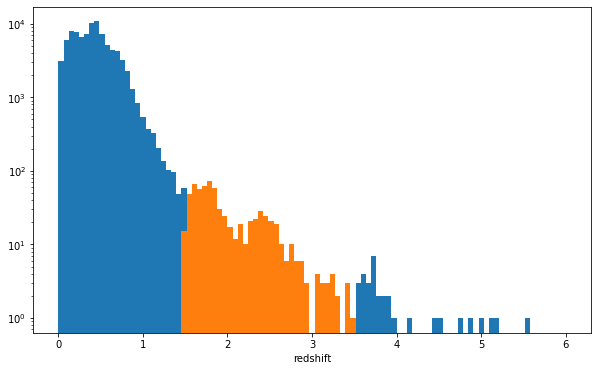

In [14]:
plt.hist(Vmax['redshift'], bins=np.linspace(0,6,100));
plt.hist(Vmax[(Vmax['redshift'] >= 1.5) & (Vmax['redshift'] <= 3.5)]['redshift'], bins=np.linspace(0,6,100));
plt.yscale('log')
plt.xlabel('redshift')

plt.show()


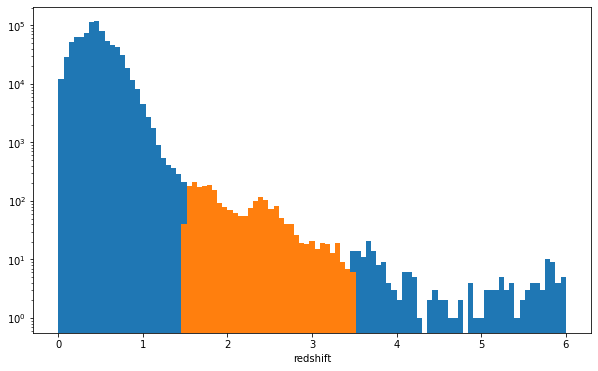

In [9]:
plt.hist(mysample['redshift'], bins=np.linspace(0,6,100));
plt.hist(mysample[(mysample['redshift'] >= 1.5) & (mysample['redshift'] <= 3.5)]['redshift'], bins=np.linspace(0,6,100));
plt.yscale('log')
plt.xlabel('redshift')

plt.show()


In [10]:
# Define sample to use
#######################
Mass = 'cigale_mstar'
redshift = 'redshift'
SFR = 'cigale_sfr'

In [ ]:
plt.hist(np.log10(Vmax[Mass]), bins=np.linspace(5,20,200), alpha=0.5, log=True, label='Mass');
plt.legend();
plt.xlabel('log(Ms)');

In [16]:
zmin = 1
zmax = 4
zind = (Vmax['redshift']>=zmin) & (Vmax['redshift'] <= zmax)

print('Total sample: ', len(mysample[zind]))
print('logM >= 11Ms: ',len(mysample[(zind) & (np.log10(mysample['cigale_mstar'])>=11)]))

Total sample:  2282
logM >= 11Ms:  622


In [ ]:
plt.figure(figsize=(10,7))
plt.plot(Vmax[Mass], Vmax[SFR], '.', markersize= 1, color='grey', label='All');
plt.plot(Vmax[zind][Mass], Vmax[zind][SFR], '.', markersize= 1, color='red', label='1<z<3');

plt.xlabel(r'$log_{10}$ Stellar Mass $(M_{\star} / M_{\odot})$')
plt.ylabel('SFR')

plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.title(FIELD)
# plt.savefig('./data/figs/Mscale_Alist_' + FIELD + '.png', format='png')

plt.show()

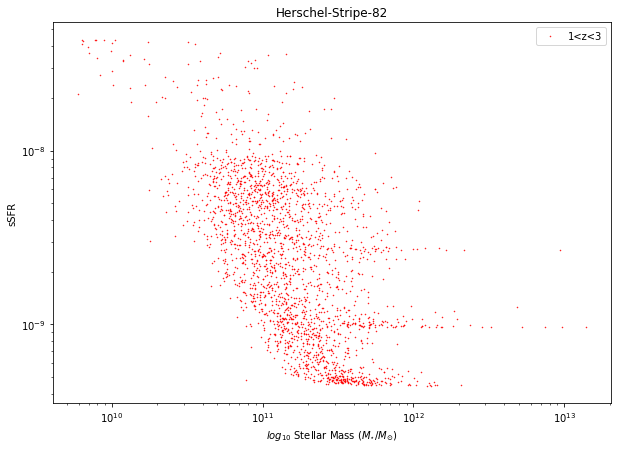

In [19]:
plt.figure(figsize=(10,7))
plt.plot(Vmax[zind][Mass], Vmax[zind][SFR]/Vmax[zind][Mass], '.', markersize= 1, color='red', label='1<z<3');

plt.xlabel(r'$log_{10}$ Stellar Mass $(M_{\star} / M_{\odot})$')
plt.ylabel('sSFR')

plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.title(FIELD)
# plt.savefig('./data/figs/Mscale_Alist_' + FIELD + '.png', format='png')

plt.show()

## 2. Vmax

Functions to use

In [11]:
def get_areas(mocs, row):
    """
    This function gets the area in which an object is observed, 
    based on whether it has been detected or not at a particular band/survey.
    
    param.
    ---------------
    mocs: dict of MOC()
        dictionary including MOCs for each survey/band.
    row: astropy.Table.row
        It should include Boolean columns for each moc_band.
    
    output
    ---------------
    area: float 
        Area in which the source have been detected (steradian).
    """
    
    areas = MOC()
    for key in mocs.keys():
#         print('getting area from ', key)
        if row['moc_'+key] == True:
#             print('It is in')
            areas += mocs[key]
        else:
#             print('it\'s not in')
            continue
    
    area = areas.area
    print('area: ', area)
    
    return area


#     areas = MOC()
    
#     moc_areas = MOC()
# #     [moc_areas :=  moc_areas + mocs_files[k] for k in mband if k in mocs_files]
#     [moc_areas :=  moc_areas + mocs_files[k] for k in mocs.keys() if row['moc_'+k]==True]
    
#     area = moc_areas.area
#     print('area: ', area)
    
#     return area

In [12]:
def select_sample_at_z(catalogue, allbands, mocs, flims, ndet=2):
    """
    
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue 
    allbands: list [[..., str]]
        Names of bands used in the selections: [[opt_bands], [nir_bands], [mir_bands]]
    mocs: dict of MOC()
        Dictionary including MOCs for each survey/band.
    flims: dict
        Flux cuts limits for each band.
    ndet: int
        Number of detections required per group of bands (opt/nir/mid). 
        Default 2; it requires 2 detection on each to pass the selection.
    
    output
    ---------------
    nb_band: astropy.Table 
        Table with selected sources -has at least "ndet" detections above the magnitude cut.
        And the area in which each source has been observed.
    """
    
    import numpy as np
    from astropy.table import Column, Table, join
    import time
    from pymoc import MOC
    
    nb_band = {}
    nb_band['help_id'] = catalogue['help_id']
    nb = ['optband', 'nirband', 'mirband']
    nx = ['optvalue', 'nirvalue', 'mirvalue']
    
    catalogue.add_column(Column(data=np.full(len(catalogue), np.empty(1)), dtype='object', 
                       name='areas'))

    r_filter = np.zeros(len(catalogue))
    names_= []
    for idx, bands in enumerate(allbands):
        nb_band[nb[idx]] = np.zeros(len(catalogue))
        nb_filter = np.zeros(len(catalogue))

        for i, filt in enumerate(bands):
            mocs_filt = [[k,f] for k,f in flims.items() if filt in k]
            ind = np.zeros(len(catalogue))
#             print('filter: ', filt)
            for key, val in mocs_filt :
#                 print('k: ', key)
#                 print('val: ', val)
                names_.append('moc_'+key)
                catalogue['moc_'+key] = catalogue['f_'+filt] >= val 
                ind_filter = 1 * (catalogue['f_'+filt] >= val)
                ind += ind_filter
            # As we can have two detections in the same filter in different surveys, e.g.: DECaLS_g and DECam_g    
            ind = 1 * (ind > 0)
            nb_filter += ind  
            
            if '_r' in filt:
                r_filter += ind 

        # sources detected in at least two filters of those bands (opt, nir, mir)
        if idx==2:
            n = 2
        else:
            n = 1
        # add flag: 1 * opt ; 2 * nir ; 4 * mir    
        nb_band[nb[idx]] += (idx+n) * (nb_filter >= ndet)
        
    print('sf allbands loop done')
    
    nb_band = Table(nb_band)
    # at least 1det in r band
    has_r_det = 1 * (r_filter >= 1)
    nb_band['optband'] = nb_band['optband'] * has_r_det
        
    total = np.zeros(len(catalogue))
    for i in range(len(allbands)):
        total += nb_band[nb[i]]

    nb_band['ndet_total'] = total
    for name in names_:
        nb_band[name] = catalogue[name]
        
    # add areas
    print('getting areas')
    selected = nb_band['ndet_total'] == 3
    nb_band['areas'] = np.zeros(len(catalogue))
    t = time.time()
    print('getting areas for {} sources'.format(selected.sum()))
    nb_band['areas'][selected]  = catalogue[selected].to_pandas().apply(lambda x: get_areas(mocs,x), axis=1)   
    print('time getting areas: ', time.time() - t)
    
    return nb_band

In [13]:
def get_fluxes_at_z(sed_cat, sed_bands, r):
    """
    This function gets the fluxes of each source at the given bands, at a particular redshift "r"
    by redshifting the sed using CIGALE.
    
    param.
    ---------------
    sed_cat: pcigale.sed
        sed of the source at the restframe.
    sed_bands: list
        name of filters to compute the flux in cigale.
    
    output
    ---------------
    cat: astropy.Table 
        Catalogue containing the fluxes of each source at the given redshift.
    """
    cat = sed_cat.copy()
    new_sed = 'sed_z'+str(r)
    cat.add_column(Column(data=np.full(len(sed_cat), np.nan), dtype='object', 
                           name=new_sed))
                          
    mod = get_module("redshifting", redshift=r)
    for i in range(len(cat)):
        sed = (cat['seds'][i]).copy()
        mod.process(sed)
        cat[new_sed][i] = sed
        
    print('sed redshifted')
    
    for band in sed_bands:
        cat['f_'+band] = cat.to_pandas().apply(lambda x: x[new_sed].compute_fnu(band), axis=1)
        
    return cat

In [14]:
def Vmax_i(area, z_min, z_max, cosmo):
    """
    """
    volume = (cosmo.comoving_volume(z_max) - cosmo.comoving_volume(z_min)) * (area/ (4* np.pi))
    return volume

In [15]:
def get_Vmax(catalogue, allbands, mocs, flims, cosmo, area, zmin, zmax, nbins=50):
    """
    It calculates the maximum volume each source can be observed, in a given redshift bin. 
    
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue 
    allbands: list [[..., str]]
        Names of bands used in the selections: [[opt_bands], [nir_bands], [mir_bands]]
    mocs: dict of MOC()
        Dictionary including MOCs for each survey/band.
    flims: dict
        Flux cuts limits for each band.
    cosmo: astropy.cosmology
        Cosmology parameters.
    zmin: float
        Minimum redshift bin.
    zmax: float
        Maximum redshift bin.
    nbins: int
        Number of dz inside the bin. 
        
    output
    ---------------
    Vmax: astropy.Table 
        Table including the Vmax calculation for each source.
    """
    
    # Bin volume
    mask = (catalogue['redshift'] >= zmin) & (catalogue['redshift'] <= zmax)
    Vmax = catalogue[mask].copy()
    Vmax['Vmax'] = 0.
    
    # Get sed at restframe
    seds_cat = catalogue[mask][['help_id','seds']]
    sed_bands = [b for band in allbands for b in band]
    
    redshifts = np.linspace(zmin, zmax, nbins)   
    z_centers = 0.5*(redshifts[1:] + redshifts[:-1])

    for i, r in enumerate(z_centers):
        start_r = time.time()
        print('z: ', r)
        dz = z_centers[1] - z_centers[0]
                
        # Redshift the sed and get the fluxes at redshift r
        start_z = time.time()
        print('start get_flux at z: ')
        z_fluxes = get_fluxes_at_z(seds_cat, sed_bands,r)
        end_z = time.time()
        print('time z flux: ', end_z - start_z)
        
        start_sf = time.time()
        ind_sf = select_sample_at_z(z_fluxes,allbands,flims, mocs)
        end_sf = time.time()
        print('time sf: ', end_sf - start_sf)
        
        # Select just galaxies with 2opt and 2NIR detection --> ndet_total == 3
        start_Vmax = time.time()
        ind = ind_sf['ndet_total'] == 3
        print('There are: ', ind.sum(), ' galaxies detected at z: ', r)
        
        # Calculate Vmax for the selected sources
        # dV =  dV/(dzdΩ) * dz * dΩ
#         dV = cosmo.differential_comoving_volume(r) * dz * ind_sf['areas'][ind] #/ (4* np.pi))
        dV = cosmo.differential_comoving_volume(r) * dz * ind_sf['areas'][ind] 
        Vmax['Vmax'][ind] = Vmax['Vmax'][ind] + dV.value
        end_Vmax = time.time()
        print('time Vmax: ', end_Vmax - start_Vmax)
        
#         print('ind_sf: ', ind_sf[:5])
#         print('Vmax: ', Vmax[:5])
    Vmax['Vmax'].unit = dV.unit * u.steradian
    
    return Vmax #,ind_sf

In [16]:
def plot_GSMF(zmin, zmax, catalogue, mcol, zcol, area, cosmo, sherman19, xlim=[8.5,13.5], ylim=[-8.5,-2.5],
             nbins=None, bin_width=None, bin_percent=None, vmax=False, savefig=False):
    """
    Plot the Galaxy Stellar Mass Function between "zmin"-"zmax".  
    
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue. 
    zmin: float
        Minimum redshift bin.
    zmax: float
        Maximum redshift bin.
    mcol: str
        Name of column for Mass
    zcol: str
        Name of column for redshift.
    nbins: int
        Number of Mass bins
    bin_width: float
        Mass bin width
    bin_percent: int
        Percentage of sources on each Mass bin.
        
    output
    ---------------
    gsmf_bins: astropy.Table 
        Table including the Mass_centers and dN_dM for each Mass bin.
    """

    ind = (~np.isnan(catalogue[mcol])) & (catalogue[mcol] > 0)
    mask = (catalogue[ind][zcol] >= zmin) & (catalogue[ind][zcol] <= zmax)

    redshifts = catalogue[ind][mask][zcol]
    Mstar = catalogue[ind][mask][mcol]
    
    Mmin = np.log10(Mstar.min())
    Mmax = np.log10(Mstar.max())
    print('Mmin: ', Mmin)
    print('Mmax: ', Mmax)
    if nbins is not None:
        limits = np.linspace(Mmin, Mmax, nbins)
        binning = 'nbins:'+str(nbins)
    
    if bin_width is not None:
        limits = np.arange(Mmin, Mmax, bin_width)
        binning = 'binwidth:'+str(bin_width)
        
    if bin_percent is not None:
        limits = [Mmin]
        binning = 'binpercent:'+str(bin_percent)
        for i in np.arange(bin_percent,100,bin_percent):
            limits.append(np.percentile(np.log10(Mstar), i))

        limits.append(Mmax)
    
    
    bins_cent = get_center(np.array(limits))
    nbins = len(bins_cent)
    
    print('Mbin centers: ', bins_cent)
    print('Mbin limits: ', limits)
           
    gsmf_bins = Table()
    gsmf_bins.add_column(Column(data=bins_cent, name='M_centers'))
    gsmf_bins.add_column(Column(np.full(len(gsmf_bins), np.nan), name='dN_dM'))
    
    for i in range(nbins):
        # Number sources per bin
        ind_bin = (np.log10(Mstar) > limits[i]) & (np.log10(Mstar) <= limits[i+1])
        dN = ind_bin.sum()
        print('#sources bin', str(i), ': ', ind_bin.sum())
        if dN == 0:
            continue

        if vmax:
#             print('Vmax True')
            Vmax = catalogue[ind][mask]['Vmax'][ind_bin]
            Vmax[Vmax==0] = np.nan
            dN_dM = np.nansum( 1 / Vmax)
#             print('dN_dM: ', dN_dM)
                  
            
        else:
#             print('Vmax False')
            Vmax = Vmax_i(area,zmin,zmax,cosmo).value
#             print('Vmax: ', Vmax)

            # Weight by 1/Vmax
            dN_dM = ind_bin.sum() / Vmax

        binwidth = limits[i+1] - limits[i]
        dN_dM = dN_dM / binwidth
        gsmf_bins['dN_dM'][i] = dN_dM 
        
        
    
    # Plot GSMF    
    plt.grid(True)
    plt.vlines(11.,-8.5, 0., colors='grey', linestyles='dashed')
    plt.plot(gsmf_bins['M_centers'] , np.log10(gsmf_bins['dN_dM']), 'o', markersize= 3, label='help')
    plt.plot(sherman19['Mcenter'], sherman19['dN_dM'], 'x', color='red', label='sherman+19')

    plt.title('{} < z < {} $\quad$ [{}]'.format(zmin, zmax, binning))
    plt.xlabel(r'$log$ Stellar Mass $(M_{\star} / M_{\odot})$')
    plt.ylabel('log φ($Mpc^{-3}$ $dex^{-1}$)')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.legend()

    if savefig==True:
        plt.savefig('./data/figs/gsmf_{}_z{}_z{}.png'.format(FIELD, str(zmin), str(zmax)))
        plt.savefig('./data/figs/gsmf_{}_z{}_z{}.pdf'.format(FIELD, str(zmin), str(zmax)))

    return gsmf_bins

In [17]:
def plot_LF(zmin, zmax, catalogue, lcol, zcol, area, cosmo,
             nbins=None, bin_width=None, bin_percent=None, vmax=False, savefig=False):
    """
    Plot the Galaxy Stellar Mass Function between "zmin"-"zmax".  
    
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue. 
    zmin: float
        Minimum redshift bin.
    zmax: float
        Maximum redshift bin.
    Lcol: str
        Name of column for Luminosity
    zcol: str
        Name of column for redshift.
    nbins: int
        Number of Mass bins
    bin_width: float
        Mass bin width
    bin_percent: int
        Percentage of sources on each Mass bin.
        
    output
    ---------------
    lf_bins: astropy.Table 
        Table including the Mass_centers and dN_dL for each Luminosity bin.
    """

    ind = (~np.isnan(catalogue[lcol])) & (catalogue[lcol] > 0)
    mask = (catalogue[ind][zcol] >= zmin) & (catalogue[ind][zcol] <= zmax)

    redshifts = catalogue[ind][mask][zcol]
    Lsun = catalogue[ind][mask][lcol]
    
    Lmin = np.log10(Lsun.min())
    Lmax = np.log10(Lsun.max())
    print('Lmin: ', Lmin)
    print('Lmax: ', Lmax)
    if nbins is not None:
        limits = np.linspace(Lmin, Lmax, nbins)
        binning = 'nbins:'+str(nbins)
    
    if bin_width is not None:
        limits = np.arange(Lmin, Lmax, bin_width)
        binning = 'binwidth:'+str(bin_width)
        
    if bin_percent is not None:
        limits = [Lmin]
        binning = 'binpercent:'+str(bin_percent)
        for i in np.arange(bin_percent,100,bin_percent):
            limits.append(np.percentile(np.log10(Lsun), i))

        limits.append(Lmax)
    
    
    bins_cent = get_center(np.array(limits))
    nbins = len(bins_cent)
    
    print('Lbin centers: ', bins_cent)
    print('Lbin limits: ', limits)
           
    lf_bins = Table()
    lf_bins.add_column(Column(data=bins_cent, name='L_centers'))
    lf_bins.add_column(Column(np.full(len(lf_bins), np.nan), name='dN_dL'))
    
    for i in range(nbins):
        # Number sources per bin
        ind_bin = (np.log10(Lsun) > limits[i]) & (np.log10(Lsun) <= limits[i+1])
        dN = ind_bin.sum()
        print('#sources bin', str(i), ': ', ind_bin.sum())
        if dN == 0:
            continue

        if vmax:
#             print('Vmax True')
            Vmax = catalogue[ind][mask]['Vmax'][ind_bin]
            Vmax[Vmax==0] = np.nan
            dN_dL = np.nansum( 1 / Vmax)
#             print('dN_dM: ', dN_dM)
                  
            
        else:
#             print('Vmax False')
            Vmax = Vmax_i(area,zmin,zmax,cosmo).value
#             print('Vmax: ', Vmax)

            # Weight by 1/Vmax
            dN_dL = ind_bin.sum() / Vmax

        binwidth = limits[i+1] - limits[i]
        dN_dL = dN_dL / binwidth
        lf_bins['dN_dL'][i] = dN_dL 
        
        
    
    # Plot GSMF    
    plt.grid(True)
#     plt.vlines(11.5,-8.5, 0., colors='grey', linestyles='dashed')
    plt.plot(lf_bins['L_centers'] , np.log10(lf_bins['dN_dL']), 'o', markersize= 3, label='help')
#     plt.plot(sherman19['Mcenter'], sherman19['dN_dM'], 'x', color='red', label='sherman+19')

    plt.title('{} < z < {} $\quad$ [{}]'.format(zmin, zmax, binning))
    plt.xlabel(r'$log$ Ldust $(L_{\odot})$')
    plt.ylabel('log φ($Mpc^{-3}$ $dex^{-1}$)')
    plt.ylim([-7.,-3.])
    plt.xlim([10.,14.])
    plt.legend()

    if savefig == True:
        plt.savefig('./data/figs/lf_{}_z{}_z{}.png'.format(FIELD, str(zmin), str(zmax)))

    return lf_bins

In [18]:
helpbands = [['sdss_u',
  'suprime_g',
  'decam_g',
  'sdss_g',
  'suprime_r',
  'decam_r',
  'sdss_r',
  'suprime_i',
  'decam_i',
  'sdss_i',
  'suprime_z',
  'decam_z',
  'sdss_z',
  'suprime_y',
  'decam_y'],
 ['vista_y',
  'ukidss_y',
  'vista_h',
  'ukidss_h',
  'vista_j',
  'ukidss_j',
  'vista_ks',
  'ukidss_k']]


In [19]:
magcuts_sdss = {'sdss_u': 22.8,
 'sdss_g': 23.7,
 'sdss_r': 23.5,
 'sdss_i': 22.9,
 'sdss_z': 21.5}

magcuts_hsc = {
    'suprime_g': 25.4,
    'suprime_r': 25.4, 
    'suprime_i': 25.1,
    'suprime_z': 24.2,
    'suprime_y': 23.7}

magcuts_des = {'decam_g_des': 23.3,
 'decam_r_des': 23.1,
 'decam_i_des': 22.7,
 'decam_z_des': 21.8,
 'decam_y_des': 20.6}

magcuts_decals =  {'decam_g_decals': 23.9, 'decam_r_decals': 23.5, 'decam_z_decals': 22.5}

# vhs - s/n > 3
magcuts_vhs = {'vista_y_vhs': 20.1,
 'vista_h_vhs': 19.6,
 'vista_j_vhs': 19.9,
 'vista_ks_vhs': 19.6}

# vics - s/n > 5
magcuts_vics = {'vista_j_vics': 21.0,
 'vista_ks_vics': 21.0}

magcuts_ukidss = {'ukidss_h':19.0, 'ukidss_j':19.0, 'ukidss_k':19.0, 'ukidss_y':20.2}

mcuts = magcuts_sdss.copy()

mcuts.update(magcuts_hsc)
mcuts.update(magcuts_des)
mcuts.update(magcuts_decals)
mcuts.update(magcuts_vhs)
mcuts.update(magcuts_vics)
mcuts.update(magcuts_ukidss)


# Calculate flux limits based on the magnitude limits
flims = {}
for key, value in mcuts.items():
    flims[key] = mag_to_flux(value)[0] * 1e3 # mJy

In [20]:
#Read mocs
moc_list = glob.glob('./data/mocs/*.fits')
len(moc_list)


mocs_files = {}
for key in flims.keys():
#     print(key)
    mocs_files[key] = MOC()
    file = [f for f in moc_list if key in f]
    mocs_files[key].read(file[0])

In [33]:
# Define sample to use
#######################
Mass = 'bayes.stellar.m_star'
redshift = 'redshift'
SFR = 'bayes.sfh.sfr10Myrs'

# Area
areamoc = MOC()
areamoc.read('./data/mocs/Uni_hs82_moc.fits')
area_hs82 = areamoc.area
area_sqdeg_hs82 = areamoc.area_sq_deg

# Cosmology parameters
######################
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) #Planck18 #FlatLambdaCDM(H0=67.77, Om0=0.3) 

In [22]:
print('hs82 total area: ', area_sqdeg_hs82 , ' sq deg.')

hs82 total area:  351.1668337228479  sq deg.


In [23]:
# Literature GSMF
#################
# Sherman2020
sh19_zbin1 = Table.read('./data/sherman/sherman2020a/bin1_sherman2020a.csv')
sh19_zbin2 = Table.read('./data/sherman/sherman2020a/bin2_sherman2020a.csv')
sh19_zbin3 = Table.read('./data/sherman/sherman2020a/bin3_sherman2020a.csv')
sh19_zbin4 = Table.read('./data/sherman/sherman2020a/bin4_sherman2020a.csv')


#McLeod2021
McL_z2 = Table.read('./data/McLeod/McLeod_z2.csv')
McL_z25 = Table.read('./data/McLeod/McLeod_z2_5.csv')
McL_z3 = Table.read('./data/McLeod/McLeod_z3.csv')

In [34]:
sample_bin1 = Vmax[(Vmax['redshift'] >= 1.5) & (Vmax['redshift'] <= 2.)]
sample_bin2 = Vmax[(Vmax['redshift'] > 2.) & (Vmax['redshift'] <= 2.5)]
sample_bin3 = Vmax[(Vmax['redshift'] > 2.5) & (Vmax['redshift'] <= 3.)]
sample_bin4 = Vmax[(Vmax['redshift'] > 3.) & (Vmax['redshift'] <= 3.5)]


In [24]:
sample_bin1 = mysample[(mysample['redshift'] >= 1.5) & (mysample['redshift'] <= 2.)]
sample_bin2 = mysample[(mysample['redshift'] > 2.) & (mysample['redshift'] <= 2.5)]
sample_bin3 = mysample[(mysample['redshift'] > 2.5) & (mysample['redshift'] <= 3.)]
sample_bin4 = mysample[(mysample['redshift'] > 3.) & (mysample['redshift'] <= 3.5)]


In [25]:
# Redshifts
bin_plot = 'bin1'

if bin_plot == 'bin1':
    zmin = 1.5 
    zmax = 2.  
    sherman19 = sh19_zbin1
    sample_bin = sample_bin1
    
if bin_plot == 'bin2':
    zmin = 2. 
    zmax = 2.5  
    sherman19 = sh19_zbin2
    sample_bin = sample_bin2
    
if bin_plot == 'bin3':
    zmin = 2.5 
    zmax = 3.  
    sherman19 = sh19_zbin3
    sample_bin = sample_bin3
    
if bin_plot == 'bin4':
    zmin = 3. 
    zmax = 3.5  
    sherman19 = sh19_zbin4
    sample_bin = sample_bin4

print('------------------------------------')
print('parameters used')
print('------------------------------------')
print('Cosmology: ', cosmo)
print('Redshift bin: ', bin_plot)
print('Redshift range: ', zmin , ' < z < ', zmax)
# print('Area: ', u.steradian.to(u.deg**2, area_used), 'sq_deg.')
print('------------------------------------')

------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin1
Redshift range:  1.5  < z <  2.0
------------------------------------


In [28]:
print('There are {} sources in bin1: 1.5 < z < 2'.format(len(sample_bin1)))
print('There are {} sources in bin2: 2 < z < 2.5'.format(len(sample_bin2)))
print('There are {} sources in bin3: 2.5 < z < 3'.format(len(sample_bin3)))
print('There are {} sources in bin4: 3 < z < 3.5'.format(len(sample_bin4)))

print('There are {} total sources in 1.5 < z < 3.5'.format(len(sample_bin1) + len(sample_bin2) + len(sample_bin3)))

There are 1298 sources in bin1: 1.5 < z < 2
There are 662 sources in bin2: 2 < z < 2.5
There are 341 sources in bin3: 2.5 < z < 3
There are 117 sources in bin4: 3 < z < 3.5
There are 2301 total sources in 1.5 < z < 3.5


In [22]:
len(Vmax[(Vmax['redshift'] >= 1.) & (Vmax['redshift'] <= 1.5)])

1570

In [36]:
sample_bin1_volume_sk = get_Vmax(sample_bin,helpbands,flims, mocs_files,cosmo,zmin, zmax, nbins=20)

In [236]:
cols = ['help_id',
 'ra',
 'dec',
 'redshift',
 'zspec',
 'cigale_mstar',
 'cigale_mstar_err',
 'cigale_sfr',
 'cigale_sfr_err',
#         'areas',
 'Vmax']
sample_bin1_volume_sk[cols].write('./data/sample_bin1_volume_dAreaXallsky_new_get_areas.fits', overwrite=True)

In [35]:
sample_bin1_volume = Table.read('./data/sample_bin1_volume_dArea.fits')
sample_bin1_volume_sk = Table.read('./data/sample_bin1_volume_dAreaXallsky.fits')

sample_bin2_volume = Table.read('./data/sample_bin2_volume_dArea.fits')
sample_bin2_volume_sk = Table.read('./data/sample_bin2_volume_dAreaXallsky.fits')

sample_bin3_volume = Table.read('./data/sample_bin3_volume_dArea.fits')
sample_bin3_volume_sk = Table.read('./data/sample_bin3_volume_dAreaXallsky.fits')

sample_bin4_volume = Table.read('./data/sample_bin4_volume_dArea.fits')
sample_bin4_volume_sk = Table.read('./data/sample_bin4_volume_dAreaXallsky.fits')

(9.0, 13.0)

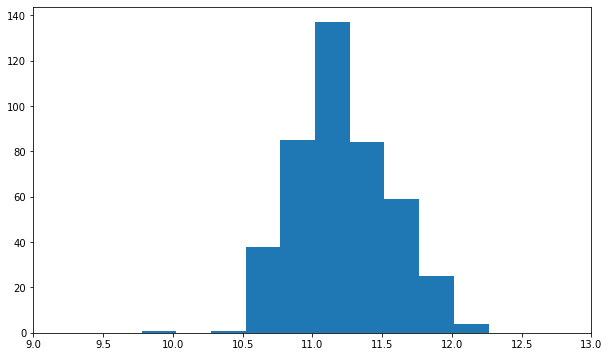

In [36]:
plt.hist(np.log10(sample_bin1_volume_sk['cigale_mstar']));
plt.xlim(9,13)

In [86]:
test_lf[:5]

help_id,optband,nirband,ndet_total,field,ra_1,dec_1,hp_idx,ebv,redshift,zspec_1,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar_1,cigale_mstar_err_1,cigale_sfr_1,cigale_sfr_err_1,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,cigale_chi2_opt,cigale_chi2_ir,cigale_chi2_red,cigale_chi2_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag,f_best_u,ferr_best_u,m_best_u,merr_best_u,flag_best_u,f_best_g,ferr_best_g,m_best_g,merr_best_g,flag_best_g,f_best_r,ferr_best_r,m_best_r,merr_best_r,flag_best_r,f_best_i,ferr_best_i,m_best_i,merr_best_i,flag_best_i,f_best_z,ferr_best_z,m_best_z,merr_best_z,flag_best_z,f_best_y,ferr_best_y,m_best_y,merr_best_y,flag_best_y,f_best_j,ferr_best_j,m_best_j,merr_best_j,flag_best_j,f_best_h,ferr_best_h,m_best_h,merr_best_h,flag_best_h,f_best_k,ferr_best_k,m_best_k,merr_best_k,flag_best_k,f_best_ks,ferr_best_ks,m_best_ks,merr_best_ks,flag_best_ks,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,flag_irac_i1,flag_irac_i2,flag_irac_i3,flag_irac_i4,sSFR,ra_2,dec_2,redshift_2,zspec_2,cigale_mstar_2,cigale_mstar_err_2,cigale_sfr_2,cigale_sfr_err_2,Vmax
,,,,,deg,deg,,,,,uJy,uJy,,uJy,uJy,,uJy,uJy,,solMass,solMass,solMass / yr,solMass / yr,W,W,W,W,,,,,,,,,,,,,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,,uJy,uJy,,uJy,uJy,,,,,,solMass / yr,deg,deg,,,solMass,solMass,solMass / yr,solMass / yr,Mpc3
bytes27,float64,float64,float64,bytes18,float64,float64,int64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes20,bool,bool,int64,int64,int64,int64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HELP_J000059.378-051309.909,1.0,2.0,3.0,Herschel-Stripe-82,0.24740834392778197,-5.219419167978541,284417693,0.02719067449754497,1.5502,nan,17504.90625,8217.9794921875,False,19527.484375,8373.603515625,False,7894.46826171875,6724.71630859375,True,70787277213.0492,17105300408.28461,445.1719145247969,79.75575989225959,7.523758255882182e+38,9.297990805134874e+37,6.4771613425202036e+38,1.9194722831050522e+38,1.9107936856066858,0.107301136080686,6.348285836595183,0.010181352380017925,0.9832166433334351,decam_stellarity,False,False,3,3,3,-99,False,nan,nan,nan,nan,False,27.201005667494996,0.26639976988147956,20.31353759765625,0.010633425787091255,False,38.03995729855895,0.3233218482085762,19.949399948120117,0.00922825001180172,False,41.054858817883144,0.6622971368619,19.866588592529297,0.01751510053873062,False,46.80851459736457,1.5304882533497581,19.72418785095215,0.035500090569257736,False,40.903465183718,2.2171372015949014,19.8705997467041,0.05885139852762222,False,42.868919372558594,7.2357892990112305,19.819643020629883,0.18

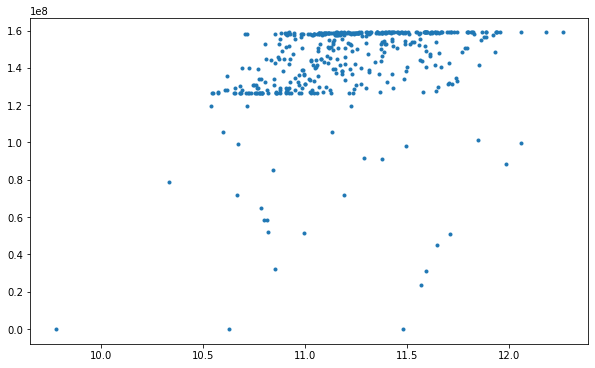

In [38]:
plt.plot(np.log10(sample_bin1_volume_sk[Mass]), sample_bin1_volume_sk['Vmax'], '.')

In [37]:
vmax_b1 = Vmax_i(area_hs82, 1.5, 2, cosmo)
vmax_b2 = Vmax_i(area_hs82, 2., 2.5, cosmo)
vmax_b3 = Vmax_i(area_hs82, 2.5, 3., cosmo)
vmax_b4 = Vmax_i(area_hs82, 3., 3.5, cosmo)


In [38]:
vmax_b1

<Quantity 1.99247996e+09 Mpc3>

Text(0, 0.5, '$V{max_i} \\quad / \\quad V_{max_{bin}}$')

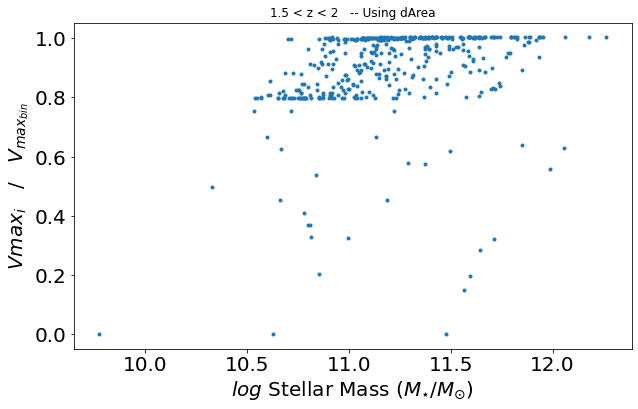

In [161]:
plt.plot(np.log10(sample_bin1_volume[Mass]), sample_bin1_volume['Vmax']/vmax_b1, '.')
plt.title(r'1.5 < z < 2   -- Using dArea')
plt.xlabel(r'$log$ Stellar Mass $(M_{\star} / M_{\odot})$')
plt.ylabel(r'$V{max_i} \quad / \quad V_{max_{bin}}$')

Text(0, 0.5, '$V{max_i} \\quad / \\quad V_{max_{bin}}$')

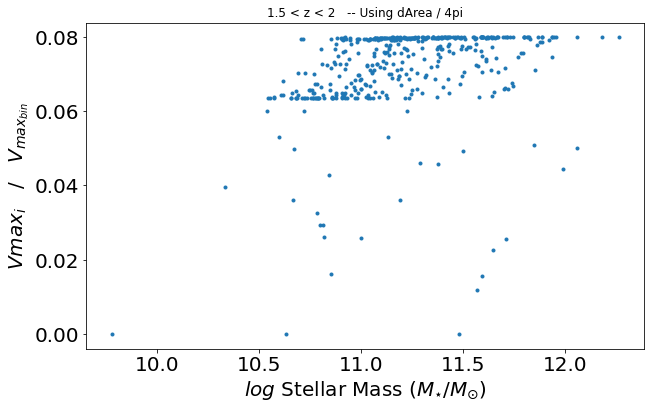

In [77]:
plt.plot(np.log10(sample_bin1_volume_sk[Mass]), sample_bin1_volume_sk['Vmax']/vmax_b1, '.')
plt.title(r'1.5 < z < 2   -- Using dArea / 4pi')
plt.xlabel(r'$log$ Stellar Mass $(M_{\star} / M_{\odot})$')
plt.ylabel(r'$V{max_i} \quad / \quad V_{max_{bin}}$')

## Plot GSMF 

- Using dArea  * AllSky_area

In [32]:
sample_bin1[:5]

help_id_1,optband,nirband,ndet_total,id,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,best.chi_square,best.reduced_chi_square,redshift,ra,dec,flag_gaia,stellarity,stellarity_origin,ebv,help_id_2,field,zspec,zspec_qual,zspec_association_flag,flag_optnir_obs,hp_idx,m_ap_suprime_g,merr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_r,merr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_i,merr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_z,merr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_y,merr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_n921,merr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,m_ap_suprime_n816,merr_ap_suprime_n816,m_suprime_n816,merr_suprime_n816,f_ap_suprime_g,ferr_ap_suprime_g,f_suprime_g,ferr_suprime_g,flag_suprime_g,f_ap_suprime_r,ferr_ap_suprime_r,f_suprime_r,ferr_suprime_r,flag_suprime_r,f_ap_suprime_i,ferr_ap_suprime_i,f_suprime_i,ferr_suprime_i,flag_suprime_i,f_ap_suprime_z,ferr_ap_suprime_z,f_suprime_z,ferr_suprime_z,flag_suprime_z,f_ap_suprime_y,ferr_ap_suprime_y,f_suprime_y,ferr_suprime_y,flag_suprime_y,f_ap_suprime_n921,ferr_ap_suprime_n921,f_suprime_n921,ferr_suprime_n921,flag_suprime_n921,f_ap_suprime_n816,ferr_ap_suprime_n816,f_suprime_n816,ferr_suprime_n816,flag_suprime_n816,f_ap_vista_y,ferr_ap_vista_y,m_ap_vista_y,merr_ap_vista_y,f_vista_y,ferr_vista_y,m_vista_y,merr_vista_y,flag_vista_y,f_ap_vista_h,ferr_ap_vista_h,m_ap_vista_h,merr_ap_vista_h,f_vista_h,ferr_vista_h,m_vista_h,merr_vista_h,flag_vista_h,f_ap_wircam_j,ferr_ap_wircam_j,m_ap_wircam_j,merr_ap_wircam_j,f_wircam_j,ferr_wircam_j,m_wircam_j,merr_wircam_j,flag_wircam_j,f_ap_vista_j,ferr_ap_vista_j,m_ap_vista_j,merr_ap_vista_j,f_vista_j,ferr_vista_j,m_vista_j,merr_vista_j,flag_vista_j,f_ap_wircam_ks,ferr_ap_wircam_ks,m_ap_wircam_ks,merr_ap_wircam_ks,f_wircam_ks,ferr_wircam_ks,m_wircam_ks,merr_wircam_ks,flag_wircam_ks,f_ap_vista_ks,ferr_ap_vista_ks,m_ap_vista_ks,merr_ap_vista_ks,f_vista_ks,ferr_vista_ks,m_vista_ks,merr_vista_ks,flag_vista_ks,m_ukidss_y,merr_ukidss_y,m_ap_ukidss_y,merr_ap_ukidss_y,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,m_ap_ukidss_h,merr_ap_ukidss_h,m_ukidss_h,merr_ukidss_h,m_ap_ukidss_k,merr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,f_ukidss_y,ferr_ukidss_y,flag_ukidss_y,f_ap_ukidss_y,ferr_ap_ukidss_y,f_ukidss_j,ferr_ukidss_j,flag_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,f_ap_ukidss_h,ferr_ap_ukidss_h,f_ukidss_h,ferr_ukidss_h,flag_ukidss_h,f_ap_ukidss_k,ferr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,flag_ukidss_k,m_ap_gpc1_g,merr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_r,merr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_i,merr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_z,merr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_y,merr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_gpc1_g,ferr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,flag_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,flag_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,flag_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,flag_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,flag_gpc1_y,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,flag_irac_i1,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,flag_irac_i2,f_ap_decam_i,ferr_ap_decam_i,m_ap_decam_i,merr_ap_decam_i,f_decam_i,ferr_decam_i,m_decam_i,merr_decam_i,flag_decam_i,f_ap_decam_y,ferr_ap_decam_y,m_ap_decam_y,merr_ap_decam_y,f_decam_y,ferr_decam_y,m_decam_y,merr_decam_y,flag_decam_y,f_ap_decam_g,ferr_ap_decam_g,m_ap_decam_g,merr_ap_decam_g,f_decam_g,ferr_decam_g,m_decam_g,merr_decam_g,flag_decam_g,f_ap_decam_r,ferr_ap_decam_r,m_ap_decam_r,merr_ap_decam_r,f_decam_r,ferr_decam_r,m_decam_r,merr_decam_r,flag_decam_r,f_ap_decam_z,ferr_ap_decam_z,m_ap_decam_z,merr_ap_decam_z,f_decam_z,ferr_decam_z,m_decam_z,merr_decam_z,flag_decam_z,m_megacam_g,merr_megacam_g,m_megacam_r,merr_

Mmin:  8.186816389943873
Mmax:  13.990632907420242
Mbin centers:  [ 8.39409555  8.80865387  9.2232122   9.63777052 10.05232884 10.46688716
 10.88144549 11.29600381 11.71056213 12.12512046 12.53967878 12.9542371
 13.36879542 13.78335375]
Mbin limits:  [ 8.18681639  8.60137471  9.01593304  9.43049136  9.84504968 10.259608
 10.67416633 11.08872465 11.50328297 11.91784129 12.33239962 12.74695794
 13.16151626 13.57607458 13.99063291]
#sources bin 0 :  0
#sources bin 1 :  2
#sources bin 2 :  0
#sources bin 3 :  1
#sources bin 4 :  2
#sources bin 5 :  34
#sources bin 6 :  380
#sources bin 7 :  445
#sources bin 8 :  241
#sources bin 9 :  137
#sources bin 10 :  46
#sources bin 11 :  5
#sources bin 12 :  3
#sources bin 13 :  1
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


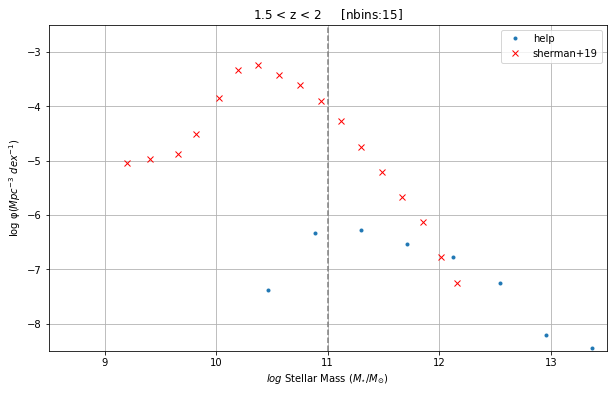

In [35]:
gsmf_b2 = plot_GSMF(1.5, 2, sample_bin1, Mass, redshift,area_hs82, cosmo, sh19_zbin1, nbins=15, vmax=False)
print('Cosmology: ', cosmo)


Mmin:  10.502511249267933
Mmax:  12.98250233274547
Mbin centers:  [10.77285639 11.12944193 11.26682984 11.38729424 11.5519038  11.74568874
 12.41334167]
Mbin limits:  [10.502511249267933, 11.043201528697391, 11.215682339096173, 11.317977344481196, 11.456611126786251, 11.647196480183261, 11.84418100794728, 12.98250233274547]
#sources bin 0 :  23
#sources bin 1 :  24
#sources bin 2 :  24
#sources bin 3 :  24
#sources bin 4 :  24
#sources bin 5 :  24
#sources bin 6 :  16
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


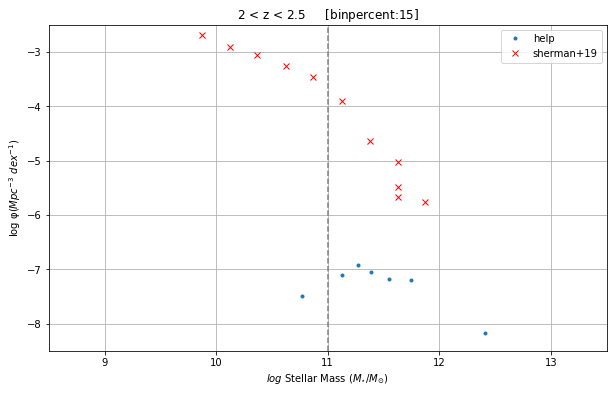

In [63]:
gsmf_b2 = plot_GSMF(2, 2.5, sample_bin2_volume, Mass, redshift,area_hs82, cosmo, McL_z25, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


In [65]:
gsmf_b2

M_centers,dN_dM
float64,float64
10.772856388982662,3.163826300331982e-08
11.129441933896782,7.708170299717591e-08
11.266829841788685,1.2173378698023712e-07
11.387294235633725,8.832749653727437e-08
11.551903803484755,6.655816093299308e-08
11.74568874406527,6.32820206681336e-08
12.413341670346375,6.734918145041514e-09


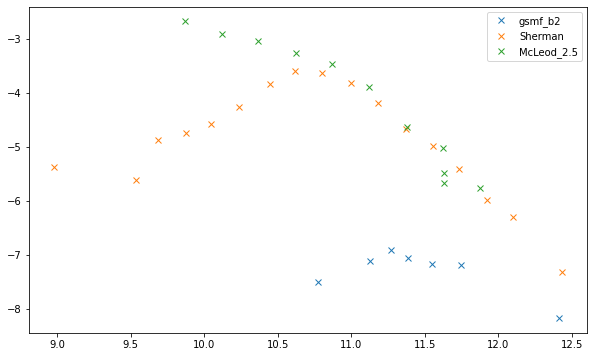

In [72]:
plt.plot(gsmf_b2['M_centers'], np.log10(gsmf_b2['dN_dM']), 'x', label='gsmf_b2');
plt.plot(sh19_zbin2['Mcenter'], sh19_zbin2['dN_dM'], 'x', label='Sherman');
plt.plot(McL_z25['Mcenter'], McL_z25['dN_dM'], 'x', label='McLeod_2.5');
plt.legend();

Mmin:  10.502511249267933
Mmax:  12.98250233274547
Mbin centers:  [10.77285639 11.12944193 11.26682984 11.38729424 11.5519038  11.74568874
 12.41334167]
Mbin limits:  [10.502511249267933, 11.043201528697391, 11.215682339096173, 11.317977344481196, 11.456611126786251, 11.647196480183261, 11.84418100794728, 12.98250233274547]
#sources bin 0 :  23
#sources bin 1 :  24
#sources bin 2 :  24
#sources bin 3 :  24
#sources bin 4 :  24
#sources bin 5 :  24
#sources bin 6 :  16
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


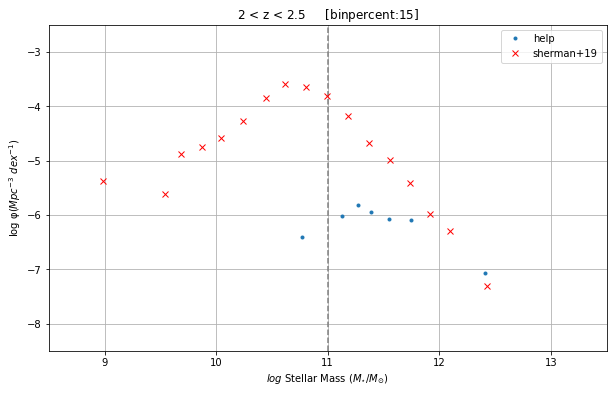

In [47]:
gsmf_b2 = plot_GSMF(2, 2.5, sample_bin2_volume_sk, Mass, redshift,area_hs82, cosmo, sh19_zbin2, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


## Plot GSMF 

- Using dArea 

In [58]:
def plot_GSMF_bins(function, area, bin_percent=15, nbins=None, vmax=True, savefig=False):

    
    while True:
        b = str(input("Enter bin number"))
        if b not in ('1', '2', '3', '4'):
            print("Enter a number between 1-4")
            #better try again... Return to the start of the loop
            continue
        else:
            break
        
    while True:
        volume = input('Use Vmax /4pi? [Y/N]')
        if volume.upper() not in ('Y', 'N'):
            print("Please enter [Y/N]")
            #better try again... Return to the start of the loop
            continue
        else:
            break
        
            
    bin_plot = 'bin' + str(b)
    print('bin: ', bin_plot)

    if bin_plot == 'bin1':
        zmin = 1.5 
        zmax = 2.  
        sherman19 = sh19_zbin1
        if volume == 'Y':
            sample_bin_vol = sample_bin1_volume_sk
            sample_name = '_sk'
        elif volume == 'N':
            sample_bin_vol = sample_bin1_volume
            sample_name = '_dA'

        else:
            print('Enter Y/N')

    if bin_plot == 'bin2':
        zmin = 2. 
        zmax = 2.5  
        sherman19 = sh19_zbin2
        if volume == 'Y':
            sample_bin_vol = sample_bin2_volume_sk
            sample_name = '_sk'
        elif volume == 'N':
            sample_bin_vol = sample_bin2_volume
            sample_name = '_dA'

        else:
            print('Enter Y/N')

    if bin_plot == 'bin3':
        zmin = 2.5 
        zmax = 3.  
        sherman19 = sh19_zbin3
        if volume == 'Y':
            sample_bin_vol = sample_bin3_volume_sk
            sample_name = '_sk'
        elif volume == 'N':
            sample_bin_vol = sample_bin3_volume
            sample_name = '_dA'

        else:
            print('Enter Y/N')
    
    if bin_plot == 'bin4':
        zmin = 3. 
        zmax = 3.5  
        sherman19 = sh19_zbin4
        if volume == 'Y':
            sample_bin_vol = sample_bin4_volume_sk
            sample_name = '_sk'
        elif volume == 'N':
            sample_bin_vol = sample_bin4_volume
            sample_name = '_dA'

        else:
            print('Enter Y/N')

    print('------------------------------------')
    print('parameters used')
    print('------------------------------------')
    print('Cosmology: ', cosmo)
    print('Redshift bin: ', bin_plot)
    print('Redshift range: ', zmin , ' < z < ', zmax)
    print('sample: ', sample_name)
    # print('Area: ', u.steradian.to(u.deg**2, area_used), 'sq_deg.')
    print('------------------------------------') 
    
    function(zmin, zmax, sample_bin_vol, Mass, redshift,  area, cosmo, sherman19, bin_percent=bin_percent, nbins=nbins, vmax=vmax, savefig=savefig)

Enter bin number 4
Use Vmax /4pi? [Y/N] N


bin:  bin4
------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin4
Redshift range:  3.0  < z <  3.5
sample:  _dA
------------------------------------
Mmin:  11.042838240866253
Mmax:  12.078352687471911
Mbin centers:  [11.21404854 11.45641904 11.61389808 11.73342099 11.79496768 11.8734094
 12.00093058]
Mbin limits:  [11.042838240866253, 11.385258846614109, 11.527579240683755, 11.70021692339597, 11.766625046861744, 11.823310317864511, 11.923508479099867, 12.078352687471911]
#sources bin 0 :  2
#sources bin 1 :  3
#sources bin 2 :  3
#sources bin 3 :  3
#sources bin 4 :  3
#sources bin 5 :  3
#sources bin 6 :  2


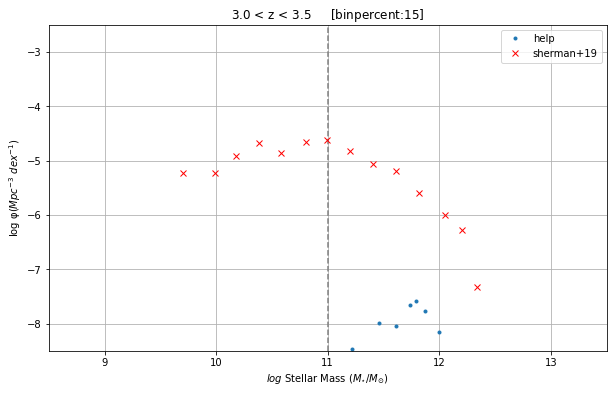

In [62]:
plot_GSMF_bins(plot_GSMF,area_hs82, vmax=True, savefig=True)

Enter bin number 2
Use Vmax /4pi? [Y/N] N


bin:  bin2
------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin2
Redshift range:  2.0  < z <  2.5
sample:  _dA
------------------------------------
Mmin:  10.502511249267933
Mmax:  12.98250233274547
Mbin centers:  [10.77285639 11.12944193 11.26682984 11.38729424 11.5519038  11.74568874
 12.41334167]
Mbin limits:  [10.502511249267933, 11.043201528697391, 11.215682339096173, 11.317977344481196, 11.456611126786251, 11.647196480183261, 11.84418100794728, 12.98250233274547]
#sources bin 0 :  23
#sources bin 1 :  24
#sources bin 2 :  24
#sources bin 3 :  24
#sources bin 4 :  24
#sources bin 5 :  24
#sources bin 6 :  16


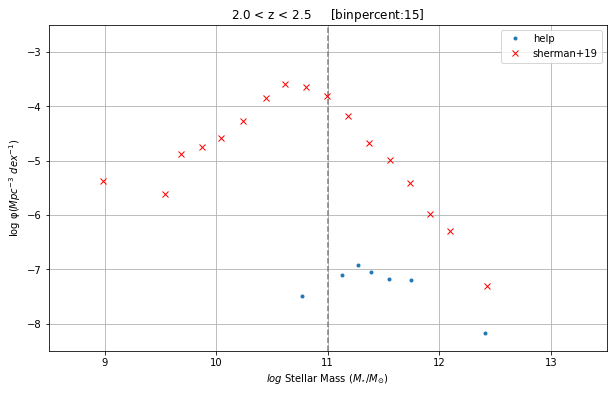

In [49]:
plot_GSMF_bins(plot_GSMF,area_hs82, vmax=True)

Enter bin number 3
Use Vmax /4pi? [Y/N] N


bin:  bin3
------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin3
Redshift range:  2.5  < z <  3.0
sample:  _dA
------------------------------------
Mmin:  10.550133725643446
Mmax:  13.141277761803643
Mbin centers:  [10.79041688 11.11849646 11.25352897 11.38708079 11.55354244 11.75123063
 12.50502532]
Mbin limits:  [10.550133725643446, 11.030700038962005, 11.206292871958857, 11.300765063551598, 11.473396508404981, 11.63368837587152, 11.868772881790402, 13.141277761803643]
#sources bin 0 :  10
#sources bin 1 :  11
#sources bin 2 :  11
#sources bin 3 :  11
#sources bin 4 :  11
#sources bin 5 :  11
#sources bin 6 :  8


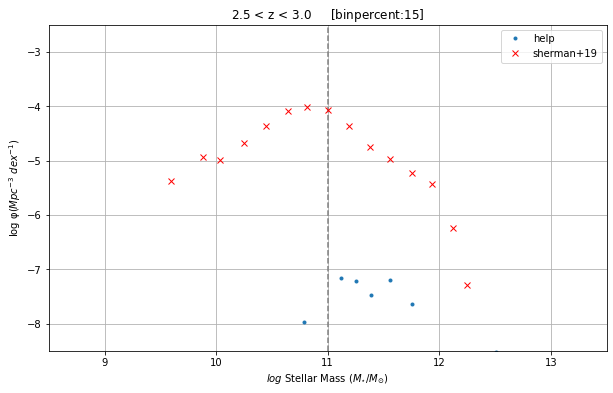

In [50]:
plot_GSMF_bins(plot_GSMF,area_hs82, vmax=True)

Enter bin number 4
Use Vmax /4pi? [Y/N] N


bin:  bin4
------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin4
Redshift range:  3.0  < z <  3.5
sample:  _dA
------------------------------------
Mmin:  11.042838240866253
Mmax:  12.078352687471911
Mbin centers:  [11.21404854 11.45641904 11.61389808 11.73342099 11.79496768 11.8734094
 12.00093058]
Mbin limits:  [11.042838240866253, 11.385258846614109, 11.527579240683755, 11.70021692339597, 11.766625046861744, 11.823310317864511, 11.923508479099867, 12.078352687471911]
#sources bin 0 :  2
#sources bin 1 :  3
#sources bin 2 :  3
#sources bin 3 :  3
#sources bin 4 :  3
#sources bin 5 :  3
#sources bin 6 :  2


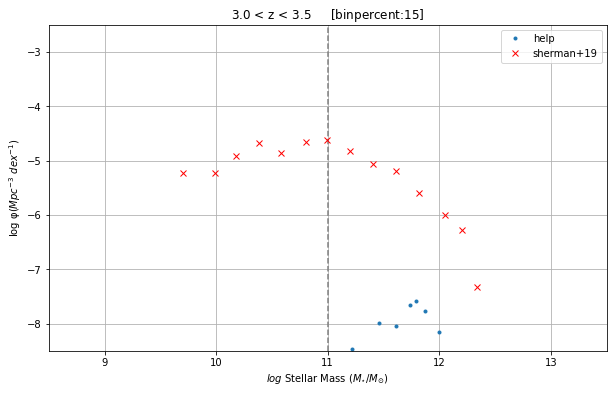

In [51]:
plot_GSMF_bins(plot_GSMF,area_hs82, vmax=True)

Enter bin number 1
Use Vmax /4pi? [Y/N] Y


bin:  bin1
------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin1
Redshift range:  1.5  < z <  2.0
sample:  _sk
------------------------------------
Mmin:  9.776023850305213
Mmax:  12.262961824819438
Mbin centers:  [10.31544891 10.94218471 11.08816009 11.20426859 11.3481006  11.55107333
 11.96530985]
Mbin limits:  [9.776023850305213, 10.85487397244675, 11.029495443393467, 11.146824736365875, 11.26171243723821, 11.434488769418792, 11.667657882314018, 12.262961824819438]
#sources bin 0 :  64
#sources bin 1 :  65
#sources bin 2 :  65
#sources bin 3 :  65
#sources bin 4 :  65
#sources bin 5 :  65
#sources bin 6 :  44


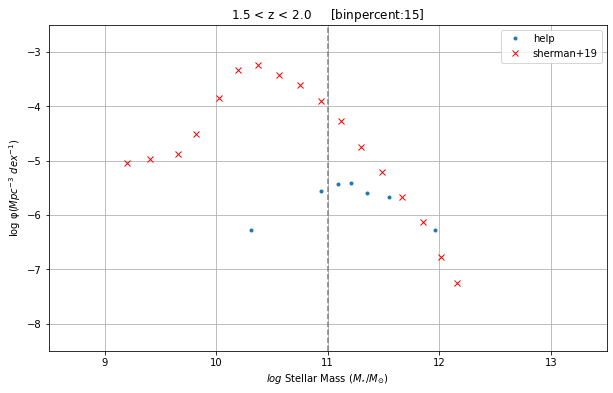

In [52]:
plot_GSMF_bins(plot_GSMF,area_hs82, vmax=True)

Enter bin number 2
Use Vmax /4pi? [Y/N] Y


bin:  bin2
------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin2
Redshift range:  2.0  < z <  2.5
sample:  _sk
------------------------------------
Mmin:  10.502511249267933
Mmax:  12.98250233274547
Mbin centers:  [10.77285639 11.12944193 11.26682984 11.38729424 11.5519038  11.74568874
 12.41334167]
Mbin limits:  [10.502511249267933, 11.043201528697391, 11.215682339096173, 11.317977344481196, 11.456611126786251, 11.647196480183261, 11.84418100794728, 12.98250233274547]
#sources bin 0 :  23
#sources bin 1 :  24
#sources bin 2 :  24
#sources bin 3 :  24
#sources bin 4 :  24
#sources bin 5 :  24
#sources bin 6 :  16


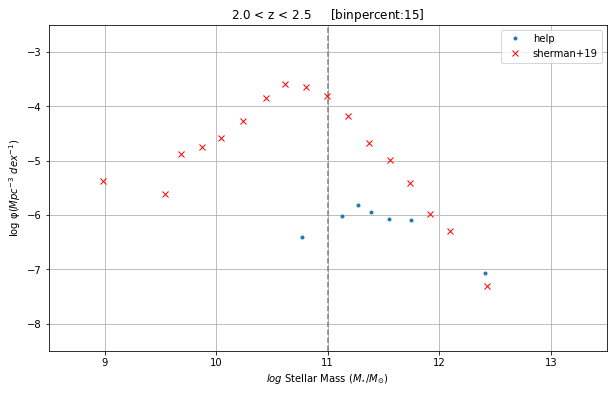

In [54]:
plot_GSMF_bins(plot_GSMF,area_hs82, vmax=True)

Enter bin number 3
Use Vmax /4pi? [Y/N] Y


bin:  bin3
------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin3
Redshift range:  2.5  < z <  3.0
sample:  _sk
------------------------------------
Mmin:  10.550133725643446
Mmax:  13.141277761803643
Mbin centers:  [10.79041688 11.11849646 11.25352897 11.38708079 11.55354244 11.75123063
 12.50502532]
Mbin limits:  [10.550133725643446, 11.030700038962005, 11.206292871958857, 11.300765063551598, 11.473396508404981, 11.63368837587152, 11.868772881790402, 13.141277761803643]
#sources bin 0 :  10
#sources bin 1 :  11
#sources bin 2 :  11
#sources bin 3 :  11
#sources bin 4 :  11
#sources bin 5 :  11
#sources bin 6 :  8


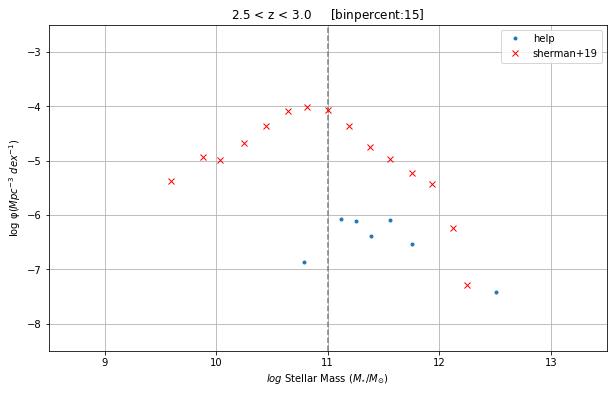

In [55]:
plot_GSMF_bins(plot_GSMF,area_hs82, vmax=True)

Enter bin number 4
Use Vmax /4pi? [Y/N] Y


bin:  bin4
------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin4
Redshift range:  3.0  < z <  3.5
sample:  _sk
------------------------------------
Mmin:  11.042838240866253
Mmax:  12.078352687471911
Mbin centers:  [11.21404854 11.45641904 11.61389808 11.73342099 11.79496768 11.8734094
 12.00093058]
Mbin limits:  [11.042838240866253, 11.385258846614109, 11.527579240683755, 11.70021692339597, 11.766625046861744, 11.823310317864511, 11.923508479099867, 12.078352687471911]
#sources bin 0 :  2
#sources bin 1 :  3
#sources bin 2 :  3
#sources bin 3 :  3
#sources bin 4 :  3
#sources bin 5 :  3
#sources bin 6 :  2


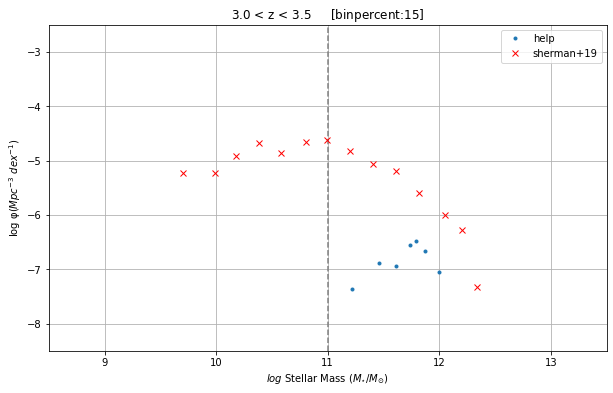

In [56]:
plot_GSMF_bins(plot_GSMF,area_hs82, vmax=True)

## Plot LF 

- Using dArea  * AllSky_area

In [42]:
sample_b1 = join(mysample, sample_bin1_volume_sk, keys='help_id')
sample_b2 = join(mysample, sample_bin2_volume_sk, keys='help_id')
sample_b3 = join(mysample, sample_bin3_volume_sk, keys='help_id')
sample_b4 = join(mysample, sample_bin4_volume_sk, keys='help_id')

In [43]:
sample_b1['redshift_1'].name = 'redshift'
sample_b2['redshift_1'].name = 'redshift'
sample_b3['redshift_1'].name = 'redshift'
sample_b4['redshift_1'].name = 'redshift'

In [44]:
Lsol = const.L_sun #watts

In [45]:
sample_b1['Ldust_L'] = sample_b1['cigale_dustlumin'] / Lsol
sample_b2['Ldust_L'] = sample_b2['cigale_dustlumin'] / Lsol
sample_b3['Ldust_L'] = sample_b3['cigale_dustlumin'] / Lsol
sample_b4['Ldust_L'] = sample_b4['cigale_dustlumin'] / Lsol

In [46]:
Ldust = 'Ldust_L'

Lmin:  11.583760378010357
Lmax:  13.277478190385525
Lbin centers:  [11.6442503  11.76523014 11.88620999 12.00718983 12.12816967 12.24914952
 12.37012936 12.49110921 12.61208905 12.73306889 12.85404874 12.97502858
 13.09600842 13.21698827]
Lbin limits:  [11.58376038 11.70474022 11.82572007 11.94669991 12.06767975 12.1886596
 12.30963944 12.43061928 12.55159913 12.67257897 12.79355882 12.91453866
 13.0355185  13.15649835 13.27747819]
#sources bin 0 :  0
#sources bin 1 :  0
#sources bin 2 :  5
#sources bin 3 :  19
#sources bin 4 :  38
#sources bin 5 :  50
#sources bin 6 :  66
#sources bin 7 :  74
#sources bin 8 :  81
#sources bin 9 :  48
#sources bin 10 :  31
#sources bin 11 :  12
#sources bin 12 :  6
#sources bin 13 :  3
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


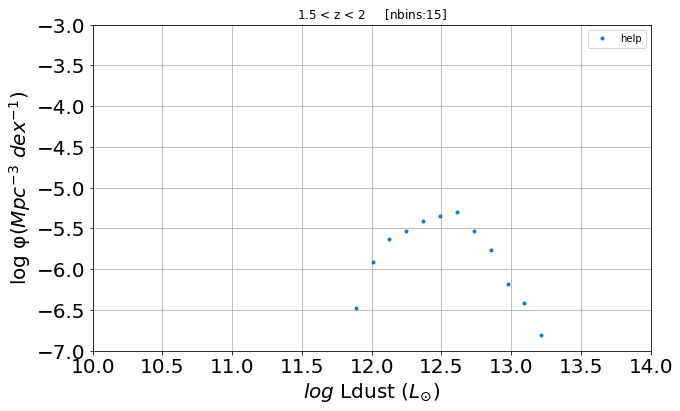

In [83]:
lf_1 = plot_LF(1.5, 2, sample_b1, Ldust, redshift, area_hs82, cosmo, nbins=15, vmax=True)
print('Cosmology: ', cosmo)


Lmin:  11.914555843822209
Lmax:  13.329197256166628
Lbin centers:  [11.96507875 12.06612457 12.16717038 12.2682162  12.36926201 12.47030783
 12.57135364 12.67239946 12.77344527 12.87449109 12.9755369  13.07658272
 13.17762853 13.27867435]
Lbin limits:  [11.91455584 12.01560166 12.11664747 12.21769329 12.3187391  12.41978492
 12.52083073 12.62187655 12.72292237 12.82396818 12.925014   13.02605981
 13.12710563 13.22815144 13.32919726]
#sources bin 0 :  1
#sources bin 1 :  2
#sources bin 2 :  2
#sources bin 3 :  5
#sources bin 4 :  17
#sources bin 5 :  14
#sources bin 6 :  24
#sources bin 7 :  28
#sources bin 8 :  23
#sources bin 9 :  21
#sources bin 10 :  8
#sources bin 11 :  9
#sources bin 12 :  2
#sources bin 13 :  2
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


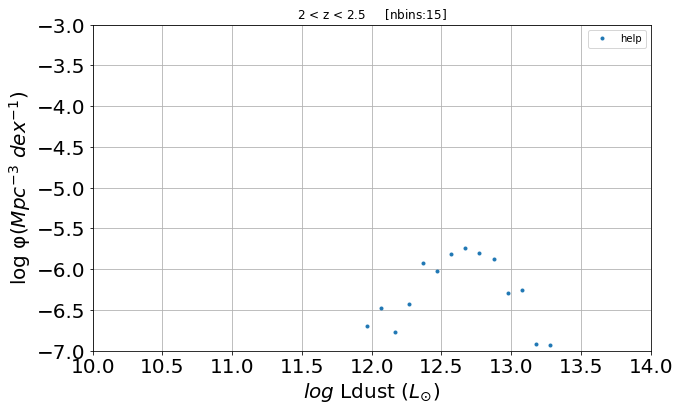

In [84]:
lf_b2 = plot_LF(2, 2.5, sample_b2, Ldust, redshift, area_hs82, cosmo, nbins=15, vmax=True)
print('Cosmology: ', cosmo)


Lmin:  11.990503737644557
Lmax:  13.492028081687003
Lbin centers:  [12.26025066 12.59170933 12.6978239  12.80757627 12.92895433 13.05267501
 13.30619763]
Lbin limits:  [11.990503737644557, 12.529997591822433, 12.6534210773905, 12.742226717240284, 12.872925831974618, 12.984982826861323, 13.1203671848948, 13.492028081687003]
#sources bin 0 :  10
#sources bin 1 :  11
#sources bin 2 :  11
#sources bin 3 :  11
#sources bin 4 :  11
#sources bin 5 :  10
#sources bin 6 :  8
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


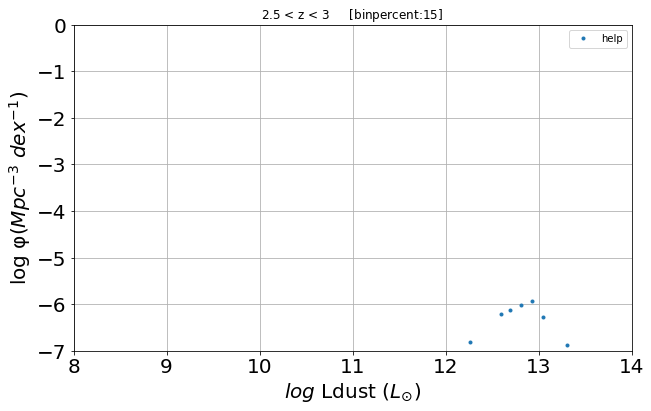

In [80]:
lf_b2 = plot_LF(2.5, 3, sample_b3, Ldust, redshift, area_hs82, cosmo, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


Lmin:  12.474502317804808
Lmax:  13.400401565106954
Lbin centers:  [12.51761357 12.70672668 12.91543281 13.10757612 13.31870836]
Lbin limits:  [12.474502317804808, 12.56072483178571, 12.852728534206074, 12.978137084115982, 13.237015155847857, 13.400401565106954]
#sources bin 0 :  3
#sources bin 1 :  4
#sources bin 2 :  4
#sources bin 3 :  4
#sources bin 4 :  4
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


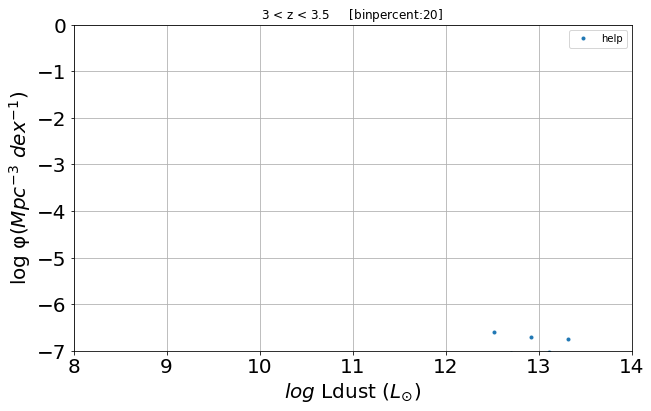

In [81]:
lf_b2 = plot_LF(3, 3.5, sample_b4, Ldust, redshift, area_hs82, cosmo, bin_percent=20, vmax=True)
print('Cosmology: ', cosmo)


In [61]:
import h5py
import pandas as pd
# from sphviewer.tools import QuickView
from matplotlib.colors import LogNorm
from virgodb import VirgoDB
# import pyread_eagle as read_eagle

plt.rcParams["axes.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
# plt.rcParams["text.usetex"] = True
np.warnings.filterwarnings('ignore')


In [82]:
# Setup the connection
user = 'zpr066'
password = 'qgzII525'
url = 'http://galaxy-catalogue.dur.ac.uk:8080/Eagle/'
vdb = VirgoDB(user, password, url)

# Example - 0 
Taken from http://icc.dur.ac.uk/Eagle/database.php

RefL0100N1504
   mass   num
0   8.1  8940
1   8.3  6599
2   8.5  4985
3   8.7  3755
4   8.9  2786
AGNdT9L0050N0752
   mass   num
0   8.1  1203
1   8.3   843
2   8.5   611
3   8.7   475
4   8.9   370
RecalL0025N0752
   mass  num
0   8.1  105
1   8.3   88
2   8.5   60
3   8.7   39
4   8.9   43


Enter bin number 1
Use Vmax /4pi? [Y/N] Y


------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin1
Redshift range:  1.5  < z <  2.0
------------------------------------
Mmin:  9.776023850305213
Mmax:  12.262961824819438
Mbin centers:  [10.31544891 10.94218471 11.08816009 11.20426859 11.3481006  11.55107333
 11.96530985]
Mbin limits:  [9.776023850305213, 10.85487397244675, 11.029495443393467, 11.146824736365875, 11.26171243723821, 11.434488769418792, 11.667657882314018, 12.262961824819438]
#sources bin 0 :  64
#sources bin 1 :  65
#sources bin 2 :  65
#sources bin 3 :  65
#sources bin 4 :  65
#sources bin 5 :  65
#sources bin 6 :  44
Cosmology:  FlatLambdaCDM(H0=67.8 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


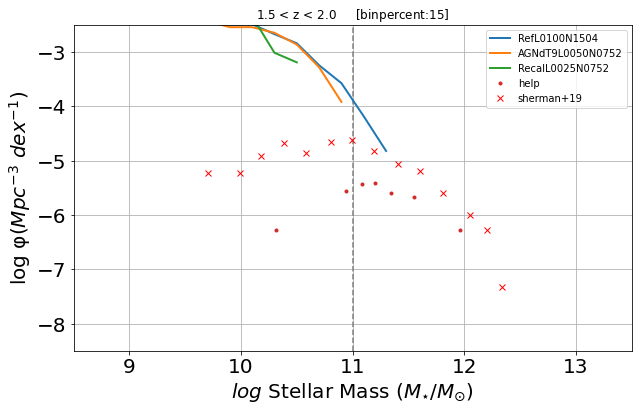

In [150]:
# Array of chosen simulations. Entries refer to the simulation name and comoving box length.
mySims= np.array([('RefL0100N1504', 100.), ('AGNdT9L0050N0752', 50.), ('RecalL0025N0752', 25.)])


for sim_name, sim_size in mySims:
    print (sim_name)
    # Construct and execute query for each simulation. This query returns the number of galaxies 
    # for a given 30 pkpc aperture stellar mass bin (centered with 0.2 dex width). 
    
    myquery = ''' SELECT        
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2 as mass,
            count(*) as num
            FROM 
            %s_SubHalo as SH,
            %s_Aperture as AP
            WHERE  
            SH.GalaxyID = AP.GalaxyID and
            AP.ApertureSize =  30 and
            AP.Mass_Star > 1e8 and       
            SH.SnapNum = 15
            GROUP BY
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2
            ORDER BY
            mass'''%(sim_name, sim_name)
            
    # Execute query.
    myData = vdb.execute_query(myquery)
    df_mydata = pd.DataFrame(myData)
    print(df_mydata[:5])

    # Normalize by volume and bin width.
    hist = myData['num'][:] / float(sim_size)**3.
    hist = hist / 0.2
    
    plt.plot(myData['mass'], np.log10(hist), label=sim_name, linewidth=2)
# plot_GSMF(zmin, zmax, cat, Mass, redshift, FlatLambdaCDM(H0=67.77, Om0=0.3), bin_percent=15, vmax=True)
plot_GSMF_bins()
print('Cosmology: ', FlatLambdaCDM(H0=67.77, Om0=0.3))

# Label plot.
#     plt.xlabel(r'log$_{10}$ M$_{*}$ [M$_{\odot}$]', fontsize=20)
#     plt.ylabel(r'log$_{10}$ dn/dlog$_{10}$(M$_{*}$) [cMpc$^{-3}$]', fontsize=20)
#     plt.tight_layout()
plt.legend()
#     plt.show()
    # plt.savefig('GSMF.png')
#     plt.close()

RefL0100N1504
   mass   num
0   8.1  8940
1   8.3  6599
2   8.5  4985
3   8.7  3755
4   8.9  2786
AGNdT9L0050N0752
   mass   num
0   8.1  1203
1   8.3   843
2   8.5   611
3   8.7   475
4   8.9   370
RecalL0025N0752
   mass  num
0   8.1  105
1   8.3   88
2   8.5   60
3   8.7   39
4   8.9   43


Enter bin number 3
Use Vmax /4pi? [Y/N] Y


------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin3
Redshift range:  2.5  < z <  3.0
------------------------------------
Mmin:  10.550133725643446
Mmax:  13.141277761803643
Mbin centers:  [10.79041688 11.11849646 11.25352897 11.38708079 11.55354244 11.75123063
 12.50502532]
Mbin limits:  [10.550133725643446, 11.030700038962005, 11.206292871958857, 11.300765063551598, 11.473396508404981, 11.63368837587152, 11.868772881790402, 13.141277761803643]
#sources bin 0 :  10
#sources bin 1 :  11
#sources bin 2 :  11
#sources bin 3 :  11
#sources bin 4 :  11
#sources bin 5 :  11
#sources bin 6 :  8
Cosmology:  FlatLambdaCDM(H0=67.8 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


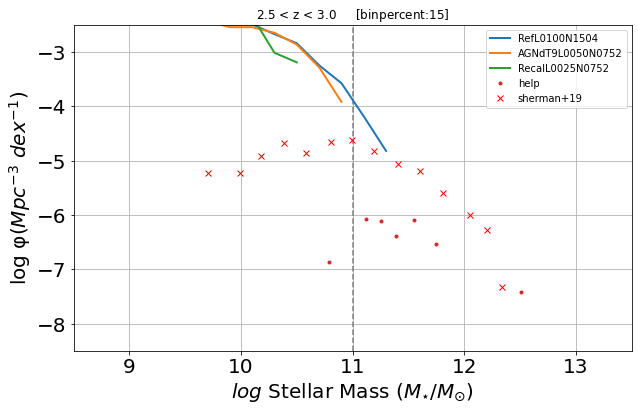

In [153]:
# Array of chosen simulations. Entries refer to the simulation name and comoving box length.
mySims= np.array([('RefL0100N1504', 100.), ('AGNdT9L0050N0752', 50.), ('RecalL0025N0752', 25.)])


for sim_name, sim_size in mySims:
    print (sim_name)
    # Construct and execute query for each simulation. This query returns the number of galaxies 
    # for a given 30 pkpc aperture stellar mass bin (centered with 0.2 dex width). 
    
    myquery = ''' SELECT        
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2 as mass,
            count(*) as num
            FROM 
            %s_SubHalo as SH,
            %s_Aperture as AP
            WHERE  
            SH.GalaxyID = AP.GalaxyID and
            AP.ApertureSize =  30 and
            AP.Mass_Star > 1e8 and       
            SH.SnapNum = 15
            GROUP BY
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2
            ORDER BY
            mass'''%(sim_name, sim_name)
            
    # Execute query.
    myData = vdb.execute_query(myquery)
    df_mydata = pd.DataFrame(myData)
    print(df_mydata[:5])

    # Normalize by volume and bin width.
    hist = myData['num'][:] / float(sim_size)**3.
    hist = hist / 0.2
    
    plt.plot(myData['mass'], np.log10(hist), label=sim_name, linewidth=2)
# plot_GSMF(zmin, zmax, cat, Mass, redshift, FlatLambdaCDM(H0=67.77, Om0=0.3), bin_percent=15, vmax=True)
plot_GSMF_bins()
print('Cosmology: ', FlatLambdaCDM(H0=67.77, Om0=0.3))

# Label plot.
#     plt.xlabel(r'log$_{10}$ M$_{*}$ [M$_{\odot}$]', fontsize=20)
#     plt.ylabel(r'log$_{10}$ dn/dlog$_{10}$(M$_{*}$) [cMpc$^{-3}$]', fontsize=20)
#     plt.tight_layout()
plt.legend()
#     plt.show()
    # plt.savefig('GSMF.png')
#     plt.close()

## III. Scaling Mass

#### Mass completeness
Pozzetti et al. (2010) and Davidzon et al. (2013): mass completeness limit of a survey is the mass of the least massive galaxy that can be detected in a given bandpass with a magnitude equal to the limiting magnitude of the survey in that bandpass. 

At each redshift, select the 20 per cent faintest objects and scale their mass log(M_s) such that their AB magnitude (m) equals the magnitude limit (m_lim) of the survey in a given bandpass:

apply to each redshift bin the Mmin computed by considering the objects inside a narrow redshift interval Δz = 0.05 centred on z_inf.

\begin{equation}
log(M_{\star, m=m_{lim}}) = log(M_{\star,CIGALE) + 0.4(m - m_{lim})
\end{equation}


In our case, to scale the M_s to the M_lim we will use the 'x = f / f_lim' values calculated before.

In [13]:
## Compute Mlim for all galaxies

In [249]:
# Pozzetti
def logMscale(cat, Mass, mag, mlim):
#     mask = ~np.isnan(cat[mag])
    Ms = cat[Mass]#[mask]
    m = cat[mag]#[mask]
    return np.log10(Ms) + 0.4 * (m - mlim)

Mass = 'cigale_mstar'

mag = 'm_best_r' 
# mlim = mcuts['decam_r_decals']
# mlim = mcuts['decam_r_des']

mag = 'm_best_ks'
# mlim = mcuts['vista_ks_vhs']
mlim = mcuts['vista_ks_vics']

In [250]:
mysample[:4]

help_id,optband,nirband,ndet_total,field,ra,dec,hp_idx,ebv,redshift,zspec,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,cigale_chi2_opt,cigale_chi2_ir,cigale_chi2_red,cigale_chi2_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag,f_best_u,ferr_best_u,m_best_u,merr_best_u,flag_best_u,f_best_g,ferr_best_g,m_best_g,merr_best_g,flag_best_g,f_best_r,ferr_best_r,m_best_r,merr_best_r,flag_best_r,f_best_i,ferr_best_i,m_best_i,merr_best_i,flag_best_i,f_best_z,ferr_best_z,m_best_z,merr_best_z,flag_best_z,f_best_y,ferr_best_y,m_best_y,merr_best_y,flag_best_y,f_best_j,ferr_best_j,m_best_j,merr_best_j,flag_best_j,f_best_h,ferr_best_h,m_best_h,merr_best_h,flag_best_h,f_best_k,ferr_best_k,m_best_k,merr_best_k,flag_best_k,f_best_ks,ferr_best_ks,m_best_ks,merr_best_ks,flag_best_ks,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,flag_irac_i1,flag_irac_i2,flag_irac_i3,flag_irac_i4,sSFR
,,,,,deg,deg,,,,,uJy,uJy,,uJy,uJy,,uJy,uJy,,solMass,solMass,solMass / yr,solMass / yr,W,W,W,W,,,,,,,,,,,,,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,,uJy,uJy,,uJy,uJy,,,,,,solMass / yr
bytes27,float64,float64,float64,bytes18,float64,float64,int64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes20,bool,bool,int64,int64,int64,int64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,bool,bool,bool,bool,float64
HELP_J000002.187-061445.916,1.0,2.0,3.0,Herschel-Stripe-82,0.009111123039974993,-6.24608767642777,284376088,0.034871156955701955,0.163,nan,179789.75,6067.265625,False,65744.6015625,7639.1484375,False,21428.58203125,8878.232421875,False,179877911299.4444,29394960727.309006,51.601867735606945,11.828451511676093,2.384601062400544e+38,2.8740710374968585e+37,1.8088417795174986e+38,6.145520781081247e+37,0.1395236409551362,0.006394075082650434,4.635404970156422,0.03465263511404564,0.05000000074505806,decam_stellarity,False,False,0,3,3,-99,False,nan,nan,nan,nan,False,159.1271308126664,0.5405060159880236,18.395639419555664,0.0036879125982522964,False,387.30652135321577,0.9056666586605819,17.42986297607422,0.002538854954764247,False,588.0144111586955,1.3059458964238544,16.976530075073242,0.0024113571271300316,False,818.1799184951855,2.398398076274358,16.617877960205078,0.0031827078200876713,False,978.6741617913505,5.982922944427278,16.423404693603516,0.006637424696236849,False,1479.2166748046875,29.609825134277344,15.974920272827148,0.021733436733484268,False,2076.770751953125,46.82686233520508,15.606528282165527,0.024481095373630524,False,nan,nan,nan,nan,False,2293.075439453125,47.70576477050781,15.498953819274902,0.02258795127272606,False,nan,nan,nan,nan,nan,nan,nan

In [258]:
Msc1 = logMscale(mysample,Mass, mag, mcuts['vista_ks_vhs'])
Msc2 = logMscale(mysample,Mass, mag, mcuts['vista_ks_vics'])

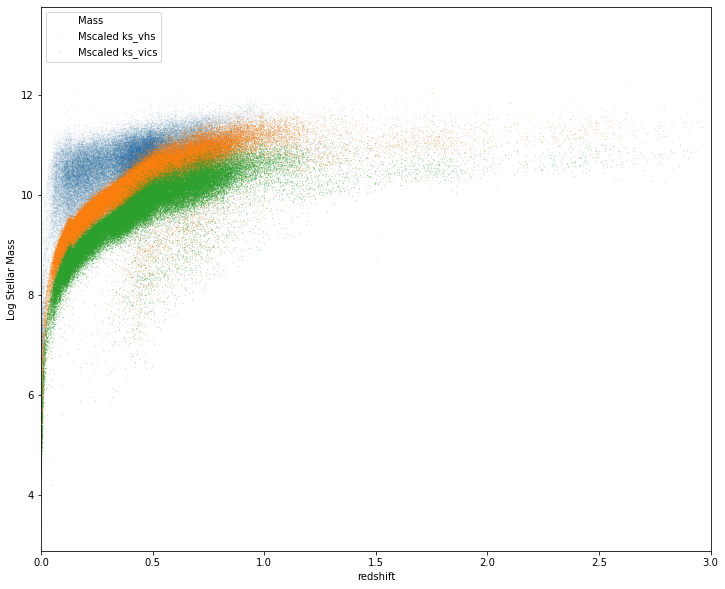

In [271]:
plt.figure(figsize=(12,10))
plt.plot(mysample[redshift], np.log10(mysample[Mass]), '.', markersize=0.05, label='Mass')
plt.plot(mysample[redshift], Msc1, '.', markersize=0.2, label='Mscaled ks_vhs')
plt.plot(mysample[redshift], Msc2, '.', markersize=0.2, label='Mscaled ks_vics')
plt.xlabel('redshift')
plt.ylabel('Log Stellar Mass')
plt.xlim(0,3)
plt.legend()
plt.show()


In [277]:
z_i = 1.5 #1.2
z_f = 3.5 #2.2
cat_bin = mysample[(mysample[redshift] >= z_i) & (mysample[redshift] <= z_f)]

In [278]:
BINNING = 'DENSITY'

if BINNING == 'WIDTH':
    ##### Binning: same width bin

    limits = np.linspace(z_i, z_f, 10)
    print('bin limits: ', limits)

    bins_cent = get_center(np.array(limits))
    print('bin centers: ', bins_cent)

if BINNING == 'DENSITY':
    ##### Binning: same #sources per bin

    limits = [z_i]
    for i in np.arange(15,100,15):
        limits.append(np.percentile(cat_bin[redshift], i))

    limits.append(z_f)

    print('bin limits: ', limits)

    bins_cent = get_center(np.array(limits))
    print('bin centers: ', bins_cent)


bin limits:  [1.5, 1.6139249999999998, 1.7245, 1.80735, 1.94618, 2.306525, 2.577470000000001, 3.5]
bin centers:  [1.5569625 1.6692125 1.765925  1.876765  2.1263525 2.4419975 3.038735 ]


In [279]:
Mlim_values = []
Mscale = np.array([])
Mscale_z = np.array([])
for i in range(len(bins_cent)):
    cat = cat_bin[(cat_bin[redshift] >= limits[i]) & (cat_bin[redshift] < limits[i+1])]
    print('length bin: ', len(cat))

    # SELECT 20% FAINTEST
    faintest = np.nanpercentile(cat[mag], 80)
    maskFaint = cat[mag] >= faintest
    cat = cat[maskFaint]

    # CALCULATE Mmin: Mass below which lie 95% of the sample
    Mlim = logMscale(cat, Mass, mag, mlim)
    Mscale = np.append(Mscale, np.array(Mlim))
    Mscale_z = np.append(Mscale_z, cat[redshift])
    mass_min = np.percentile(Mlim, 80)
    Mlim_values.append(mass_min)



length bin:  104
length bin:  102
length bin:  104
length bin:  103
length bin:  103
length bin:  103
length bin:  69


[(1.5569625, 11.395498199970675), (1.6692125, 11.354738406549565), (1.765925, 11.297356809181448), (1.876765, 11.327353683711104), (2.1263525000000003, 11.47433688788663), (2.4419975000000003, 11.517201343443874), (3.0387350000000004, 11.651533233321782)]


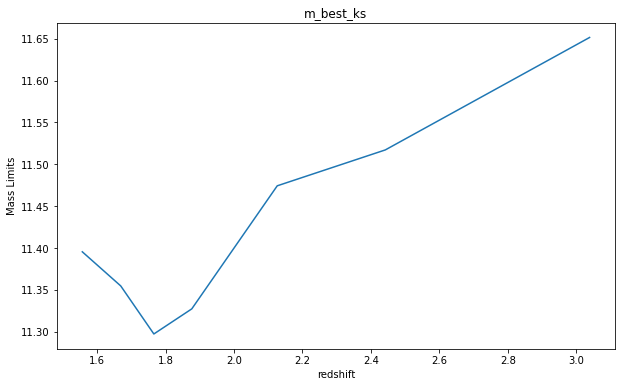

In [213]:
print(list(zip(bins_cent,Mlim_values)))

plt.plot(bins_cent, Mlim_values,'-')
plt.xlabel('redshift')
plt.ylabel('Mass Limits')
plt.title(mag)
plt.show()

[(1.5569625, 10.835498199970676), (1.6692125, 10.794738406549564), (1.765925, 10.737356809181447), (1.876765, 10.767353683711105), (2.1263525000000003, 10.91433688788663), (2.4419975000000003, 10.957201343443876), (3.0387350000000004, 11.091533233321782)]


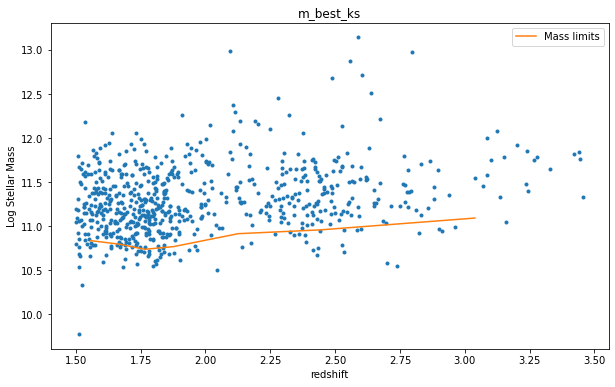

In [192]:
print(list(zip(bins_cent,Mlim_values)))

plt.plot(cat_bin[redshift], np.log10(cat_bin[Mass]),'.')
plt.plot(bins_cent, Mlim_values,'-', label='Mass limits')
plt.xlabel('redshift')
plt.ylabel('Log Stellar Mass')
plt.legend()
plt.title(mag)
plt.show()

[(1.5569625, 11.395498199970675), (1.6692125, 11.354738406549565), (1.765925, 11.297356809181448), (1.876765, 11.327353683711104), (2.1263525000000003, 11.47433688788663), (2.4419975000000003, 11.517201343443874), (3.0387350000000004, 11.651533233321782)]


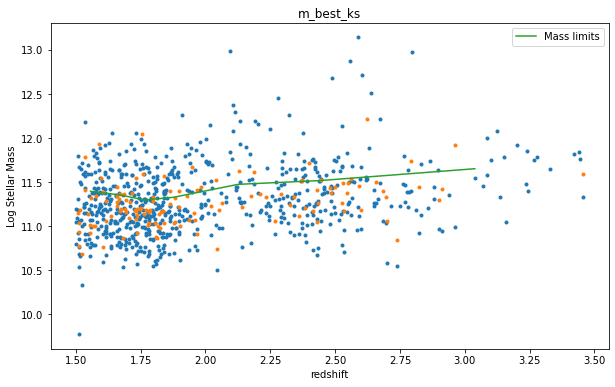

In [248]:
print(list(zip(bins_cent,Mlim_values)))

plt.plot(cat_bin[redshift], np.log10(cat_bin[Mass]),'.')
plt.plot(Mscale_z, Mscale,'.')
plt.plot(bins_cent, Mlim_values,'-', label='Mass limits')
plt.xlabel('redshift')
plt.ylabel('Log Stellar Mass')
plt.legend()
plt.title(mag)
plt.show()

In [255]:
mcuts['vista_ks_vhs']

19.6

In [256]:
mcuts['vista_ks_vics']

21.0

[(1.5569625, 10.835498199970676), (1.6692125, 10.794738406549564), (1.765925, 10.737356809181447), (1.876765, 10.767353683711105), (2.1263525000000003, 10.91433688788663), (2.4419975000000003, 10.957201343443876), (3.0387350000000004, 11.091533233321782)]


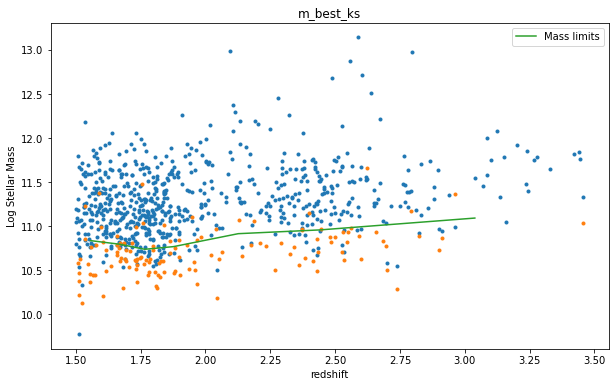

In [254]:
print(list(zip(bins_cent,Mlim_values)))

plt.plot(cat_bin[redshift], np.log10(cat_bin[Mass]),'.')
plt.plot(Mscale_z, Mscale,'.')
plt.plot(bins_cent, Mlim_values,'-', label='Mass limits')
plt.xlabel('redshift')
plt.ylabel('Log Stellar Mass')
plt.legend()
plt.title(mag)
plt.show()

[(1.5569625, 10.853378408950148), (1.6692125, 10.763795937226783), (1.765925, 10.771405362509102), (1.876765, 10.624363790252868), (2.1263525000000003, 10.91433688788663), (2.4419975000000003, 10.961102890023033), (3.0387350000000004, 11.134746246925836)]


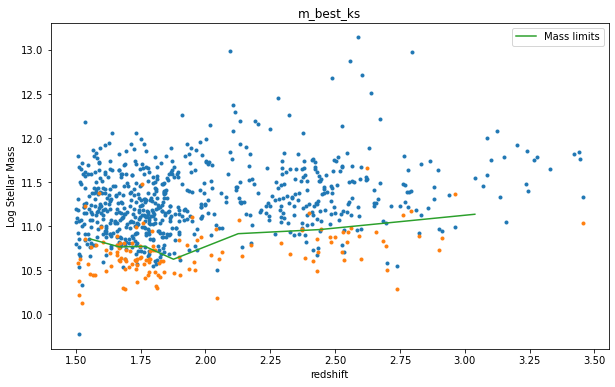

In [276]:
print(list(zip(bins_cent,Mlim_values)))

plt.plot(cat_bin[redshift], np.log10(cat_bin[Mass]),'.')
plt.plot(Mscale_z, Mscale,'.')
plt.plot(bins_cent, Mlim_values,'-', label='Mass limits')
plt.xlabel('redshift')
plt.ylabel('Log Stellar Mass')
plt.legend()
plt.title(mag)
plt.show()

[(1.5569625, 11.009490745230826), (1.6692125, 10.940805366218985), (1.765925, 11.187571334451192), (1.876765, 10.559241993956661), (2.1263525000000003, 10.746337244499214), (2.4419975000000003, 10.455296985027434), (3.0387350000000004, 10.960432081467456)]


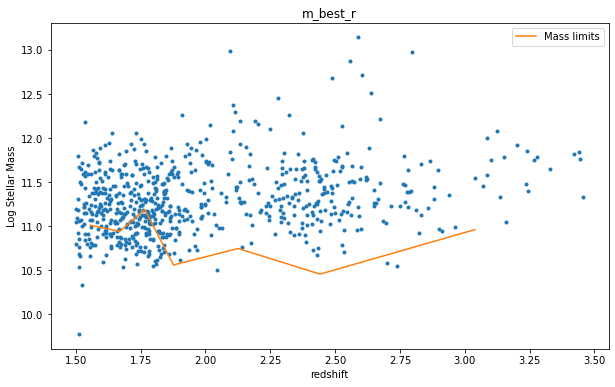

In [199]:
print(list(zip(bins_cent,Mlim_values)))

plt.plot(cat_bin[redshift], np.log10(cat_bin[Mass]),'.')
plt.plot(bins_cent, Mlim_values,'-', label='Mass limits')
plt.xlabel('redshift')
plt.ylabel('Log Stellar Mass')
plt.legend()
plt.title(mag)
plt.show()

[(1.5569625, 11.169490745230826), (1.6692125, 11.100805366218985), (1.765925, 11.34757133445119), (1.876765, 10.719241993956661), (2.1263525000000003, 10.906337244499213), (2.4419975000000003, 10.615296985027433), (3.0387350000000004, 11.120432081467454)]


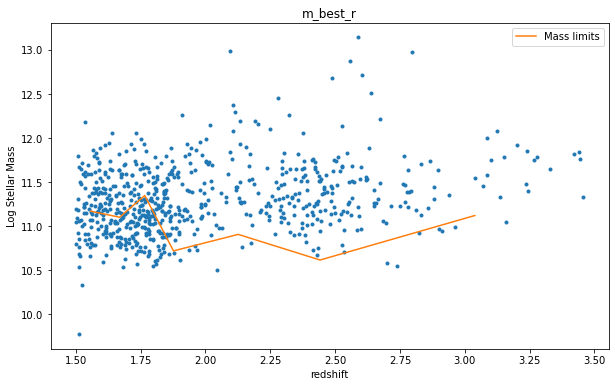

In [207]:
print(list(zip(bins_cent,Mlim_values)))

plt.plot(cat_bin[redshift], np.log10(cat_bin[Mass]),'.')
plt.plot(bins_cent, Mlim_values,'-', label='Mass limits')
plt.xlabel('redshift')
plt.ylabel('Log Stellar Mass')
plt.legend()
plt.title(mag)
plt.show()